In [5]:
# -*- coding: utf-8 -*-

In [6]:
from __future__ import division
from __future__ import print_function
from IPython.display import Audio
%matplotlib inline
from IPython.display import display
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

In [7]:
%run "speechutils.py"
%run "viewutils.ipynb"

In [4]:
with open("../../ZRTools/exp/callhome_train_120/files.lst", "w") as out_f:
    for fil in ch.b_wav_files:
        print(fil, file=out_f)

NameError: name 'ch' is not defined

In [8]:
ch = callhome_eval_init("config.json", fast=False, alpha=.1)
df_zrt, cols_to_show = ch.gen_zrt_df()

../../ZRTools/exp/callhome_train_20/matches/config0.80-0.90-0.80-50/master_graph.nodes
Loading prep state dictionary ...
Finished loading prep state dictionary ...
Finished ...
Finished - reading nodes ...
Processing line: 1
Finished - reading edges ...
Removing duplicates in pairs list
Set length: 19438 and List length: 43061
Generating vocabulary of English words ... 
Finished vocab ...
Generating initial belief over English translations
Processed 1 nodes
Generating similarity between nodes based on English translations ...
Finished generating similarity ...
Generating similarity between nodes based on English translations ...
Finished generating similarity ...
Processing line: 1
Processing line: 3001
Processing line: 6001
Processing line: 9001
Processing line: 12001
Processing line: 15001
Processing line: 18001
Total matches: 19438
matches with missing transcriptions: 5986
matches with only sil, sp: 20400
Finished - evaluating 19438 pairs ...
Setting up eval data frame
Finished ...


In [9]:
dur_ms = 0
full_dur_ms = 0
for fil in ch.b_vad_files:
    with open(fil.replace('.tvad', '.tvad'), "r") as in_f:
        for line in in_f:
            line_items = map(int, line.strip().split())
            curr_ms = ((line_items[1] - line_items[0]) * 10)
            dur_ms += (curr_ms if curr_ms >= 500 else 0)
            full_dur_ms += curr_ms
print("Total number of files: %d" % len(ch.b_vad_files))
print("duration: %d (ms), %.2f (hours)" %(dur_ms, dur_ms / (1000 * 3600)))
print("full duration: %d (ms), %.2f (hours)" %(full_dur_ms, full_dur_ms / (1000 * 3600)))

Total number of files: 3716
duration: 9948440 (ms), 2.76 (hours)
full duration: 10132170 (ms), 2.81 (hours)


In [6]:
ch.b_vad_files[0]

'../../corpora/callhome_es/out/002.001.tvad'

In [10]:
alpha = 0.4
ch.interpolate_sim(alpha)
df_zrt, cols_to_show = ch.gen_zrt_df()

Interpolating similarity matrix ...
Finished interpolating similarity matrix ...
Updating data frame ...
Finished updating data frame ...


# Analyse ZRT output

### Set up visualizations

In [11]:
def display_pair_and_plot_dtw(pair_id, tosave=False, \
                              offset_1=(0,-1), \
                              offset_2=(0,-1), \
                              n_labels=("pair 1", "node 1", "node 2"), phones=False):
    display(Audio(ch.play_pair_wav(pair_id)))

    pair_info = ch.eval_pairs_list[pair_id]
    node_1 = ch.node_dict[pair_info['n1']]
    node_2 = ch.node_dict[pair_info['n2']]


    wav_1 = ch.file_info_dict[node_1.wav_fil].target_file+".wav"
    wav_2 = ch.file_info_dict[node_2.wav_fil].target_file+".wav"


    if not phones:
        es_words_1 = ch.es_words_dict[node_1.wav_fil]
        es_words_2 = ch.es_words_dict[node_2.wav_fil]
    else:
        es_words_1 = ch.es_phones_dict[node_1.wav_fil]
        es_words_2 = ch.es_phones_dict[node_2.wav_fil]
    #plot_name = "output/dtw_pair_1761_1762.pdf"
    # print(wav_1, wav_2)
    # print(es_words_1, es_words_2)
    wav_1_time = (node_1.start, node_1.end)
    wav_2_time = (node_2.start, node_2.end)
    plot_name = "output/{0:d}.pdf".format(pair_id)
    if not tosave:
        plot_name = ""
        
    plot_dtw(wav_1, wav_2, es_words_1, es_words_2, \
             wav_1_time, wav_2_time, pair_info['zrt_sim'], plot_name, \
             offset_1, offset_2, n_labels)

In [12]:
pd.options.display.float_format = '{:,.3f}'.format

In [10]:
# display(df_zrt.head(1))
# display(df_zrt[cols_to_show].head(1))
# print(df_zrt.columns)

## Pairs discovered

### Filter Pairs

In [13]:
# Pairs with no matches in ES transcripts or only ['sil','sp'] matches
df_no_mtch_sil_only = df_zrt[(df_zrt['no_mtch'] == True) | (df_zrt['sil_only'] == True)]
# Pairs only ['sil','sp'] matches
df_sil_only = df_zrt[(df_zrt['sil_only'] == True)]
# Pairs with no matches in ES transcripts, but no ['sil','sp'] detected
df_no_mtch_not_sil = df_zrt[(df_zrt['no_mtch'] == True) & (df_zrt['sil_only'] == False)]

# Pairs with ES words found for both nodes
# df_valid = df_zrt[(df_zrt['no_mtch'] == False) & (df_zrt['sil_only'] == False)]
df_valid = df_zrt[(df_zrt['no_mtch'] == False) & (df_zrt['sil_only'] == False) & (df_zrt['sil_major'] == False)]

# Filtering two files:
# df_valid = df_valid[df_valid.apply(lambda row: remove_invalid_files(row), axis=1)]
# df_valid = df_valid[df_valid['dur'] > 600]

# out_t = PrettyTable(["Description", "# of pairs"], hrules=True)
out_t = PrettyTable(["Description", "# of pairs"])
out_t.align['Description'] = 'r'
out_t.add_row(["Total pairs", len(df_zrt)])
out_t.add_row(["With sil, sp, or no matches", len(df_no_mtch_sil_only)])
out_t.add_row(["Pairs with speech segments and ES words", len(df_valid)])
print(out_t)
# print(out_t.get_html_string())
df_goodish = df_valid[(df_valid['ES word match']==1)]
df_cnt_goodish = df_valid[(df_valid['ES cont match']==1)]
df_xspk_goodish = df_valid[(df_valid['ES word match']==1) & (df_valid['cross_spk']==True)]
df_cnt_xspk_goodish = df_valid[(df_valid['ES cont match']==1) & (df_valid['cross_spk']==True)]
print("Total good scores: %d, content good scores: %d" % (len(df_goodish), len(df_cnt_goodish)))
print("Total cross-speaker good scores: %d, cross-speaker content good scores: %d" % \
      (len(df_xspk_goodish), len(df_cnt_xspk_goodish)))

total_correct = len(df_cnt_goodish)
total_x_correct = len(df_cnt_xspk_goodish)
df_88_thresh_all = df_valid[(df_valid['ZRT'] >= 0.88)]
df_88_thresh_correct = df_88_thresh_all[(df_88_thresh_all['ES cont match'] == 1)]
df_cnt_xspk_total_88 = df_88_thresh_all[(df_88_thresh_all['cross_spk'] == True)]
df_cnt_xspk_good_88 = df_88_thresh_correct[(df_88_thresh_correct['cross_spk']==True)]
total_88 = len(df_88_thresh_all)
correct_88 = len(df_88_thresh_correct)
prec_88 = correct_88 / total_88
recall_88 = correct_88 / total_correct
correct_x_88 = len(df_cnt_xspk_good_88)
total_x_88 = len(df_cnt_xspk_total_88)
prec_x_88 = correct_x_88 / total_x_88
print(len(df_valid[(df_valid['cross_spk'] == True)]))

print("At DTW=0.88, total: %d, correct: %d, Precision: %.3f, Recall: %.3f \nx-spkr total: %d, x-spkr correct: %d, x-spkr prec: %.3f" % \
                                                                              (total_88, correct_88, \
                                                                              prec_88, recall_88, \
                                                                              total_x_88, correct_x_88, prec_x_88))


print(len([pair for pair in ch.eval_pairs_list if not pair['no_mtch'] and not pair['sil_only']]))
print(len([pair for pair in ch.eval_pairs_list if not pair['sil_sp']]))
print(len([pair for pair in ch.eval_pairs_list if not pair['sil_major']]))


+-----------------------------------------+------------+
|                             Description | # of pairs |
+-----------------------------------------+------------+
|                             Total pairs |   19438    |
|             With sil, sp, or no matches |    8986    |
| Pairs with speech segments and ES words |    7541    |
+-----------------------------------------+------------+
Total good scores: 1893, content good scores: 1064
Total cross-speaker good scores: 540, cross-speaker content good scores: 114
4465
At DTW=0.88, total: 2339, correct: 728, Precision: 0.311, Recall: 0.684 
x-spkr total: 797, x-spkr correct: 18, x-spkr prec: 0.023
10452
4687
8024


In [14]:
print(3542/169018)
print(3830/34995)
# ch.eval_pairs_list[0]

0.0209563478446
0.109444206315


In [14]:
df_valid.columns

Index([               u'chid1',                u'chid2',
             u'cnt_es_w_check',        u'ES cont match',
                        u'dur', u'en_w_cnt_count_sim_0',
                     u'EN sim',  u'en_w_cnt_jcrd_sim_0',
           u'en_w_count_sim_0',       u'en_w_hgr_sim_0',
            u'en_w_jcrd_sim_0',    u'ES phone edit sim',
                u'ES words n1',          u'ES words n2',
              u'ES word match',                   u'n1',
                         u'n2',              u'no_mtch',
                  u'sil_major',             u'sil_only',
                     u'sil_sp',                 u'uid1',
                       u'uid2',                  u'ZRT',
                       u'spk1',                 u'spk2',
                  u'cross_spk',            u'sim mixed',
                   u'sim jcrd',            u'sim match'],
      dtype='object')

In [28]:
alpha = 0.1
ch.interpolate_sim(alpha)

ap_all = []
acc_all = []
ap_x = []
acc_x = []

for alpha in np.arange(0,1.1,.1):
    print(alpha)
    # Interpolate translation similarity
    ch.interpolate_sim(alpha)
    
    # Calculate avg precision, accuracy for all matches
    p_z, r_z, ir_z  = ch.eval_precision_recall(eval_col='cnt_es_w_sim', sim_col='sim jcrd', cross_spk=False)
    ap_all.append(np.trapz(p_z[::-1], r_z[::-1]))
    acc_all.append(np.trapz(r_z[::-1], ir_z[::-1]))
    
    # Calculate avg precision, accuracy for cross-speaker matches
    p_x, r_x, ir_x  = ch.eval_precision_recall(eval_col='cnt_es_w_sim', sim_col='sim jcrd', cross_spk=True)
    ap_x.append(np.trapz(p_x[::-1], r_x[::-1]))
    acc_x.append(np.trapz(r_x[::-1], ir_x[::-1]))

print([float("{0:.4f}".format(x)) for x in ap_all])
print([float("{0:.4f}".format(x)) for x in acc_all])
print([float("{0:.4f}".format(x)) for x in ap_x])
print([float("{0:.4f}".format(x)) for x in acc_x])

Interpolating similarity matrix ...
Finished interpolating similarity matrix ...
Updating data frame ...
Finished updating data frame ...
0.0
Interpolating similarity matrix ...
Finished interpolating similarity matrix ...
Updating data frame ...
Finished updating data frame ...
Computing precision recall, cross speaker = 0
# eval scores: 169018
# good scores: 7315
#  bad scores: 161703
Average Precision - using sim: sim jcrd
----------------------------------------
	0.12076
----------------------------------------
Accuracy - using sim: sim jcrd
----------------------------------------
	0.72704
----------------------------------------
Computing precision recall, cross speaker = 1
# eval scores: 169018
# good scores: 3542
#  bad scores: 11450
Average Precision - using sim: sim jcrd
----------------------------------------
	0.02946
----------------------------------------
Accuracy - using sim: sim jcrd
----------------------------------------
	0.41162
------------------------------------

Computing precision recall, cross speaker = 0
# eval scores: 169018
# good scores: 7315
#  bad scores: 161703
Average Precision - using sim: sim jcrd
----------------------------------------
	0.32856
----------------------------------------
Accuracy - using sim: sim jcrd
----------------------------------------
	0.78107
----------------------------------------


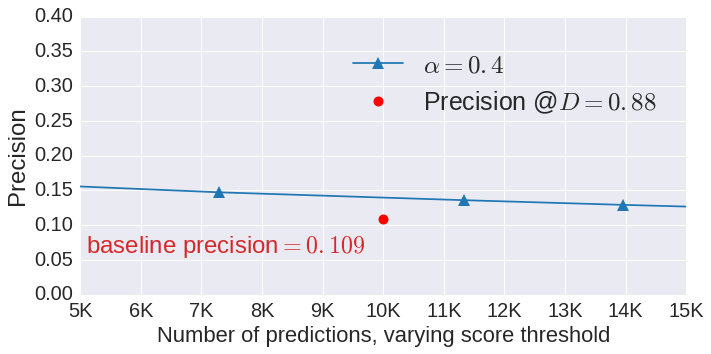

In [31]:
# _, _, _ = ch.eval_precision_recall(eval_col='cnt_es_w_sim', cross_spk=True)
p_best, r_best, ir_best = ch.eval_precision_recall(eval_col='cnt_es_w_sim', sim_col='sim jcrd', cross_spk=False)

num_correct = []
num_predicted = []
for p, r in zip(p_best, r_best):
    correct = total_correct * r
    if p == 0:
        predicted = 0
    else:
        predicted = correct / p
    num_correct.append(correct)
    num_predicted.append(predicted)

num_correct = np.array(num_correct, dtype=np.int)
num_predicted = np.array(num_predicted, dtype=np.int)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.xaxis.set_major_locator(MultipleLocator(1000))
plt.xticks(rotation=0, size=20)
plt.yticks(size=20)
plt.xlim(30000, 40000)
plt.ylim(0, .40)
# ax[0].plot(num_correct, p_best)
ax.plot(num_predicted, p_best, label=r"$\alpha=0.4$", c=tableau20[0], marker='^', markersize=12)
ax.plot(total_88, prec_88, 'or', label=r"Precision @$D=0.88$", markersize=10)
ax.text(total_88-2600, prec_88-.04, "baseline precision$={0:.3f}$".format(prec_88), size=24, ha="center", va="center",\
                   rotation=0, color=tableau20[6])
# ax.set_title('Precision vs Predictions, 50:FA, All matches', size=24, y=1.02)
ax.legend(loc='upper center', bbox_to_anchor=(0.7, 0.95),
                  ncol=1, fancybox=True, shadow=True, fontsize=25)
# plt.hlines(.21, 0, total_88, linestyles='--', color=tableau20[0], linewidth=4)
# plt.vlines(total_88, 0, 0.21, linestyles='--', color=tableau20[0], linewidth=4)
# plt.hlines(prec_88, 0, 15500, linestyles='--', color=tableau20[4], linewidth=4)
# plt.vlines(15500, 0, prec_88, linestyles='--', color=tableau20[4], linewidth=4)

ax.set_ylabel("Precision", size=24)
ax.set_xlabel("Number of predictions, varying score threshold", size=22)
count_labels = ["{0:d}K".format(x) for x in range(4,17)]
ax.set_xticklabels(count_labels, size=20)
fig.tight_layout()
# fig.savefig("output/prec_pred_120.pdf")
# display(zip(p_best, r_best, num_correct, num_predicted))

Computing precision recall, cross speaker = 1
# eval scores: 43762
# good scores: 963
#  bad scores: 6232
Average Precision - using sim: sim jcrd
----------------------------------------
	0.12754
----------------------------------------
Accuracy - using sim: sim jcrd
----------------------------------------
	0.52640
----------------------------------------
0.042100630776 6817


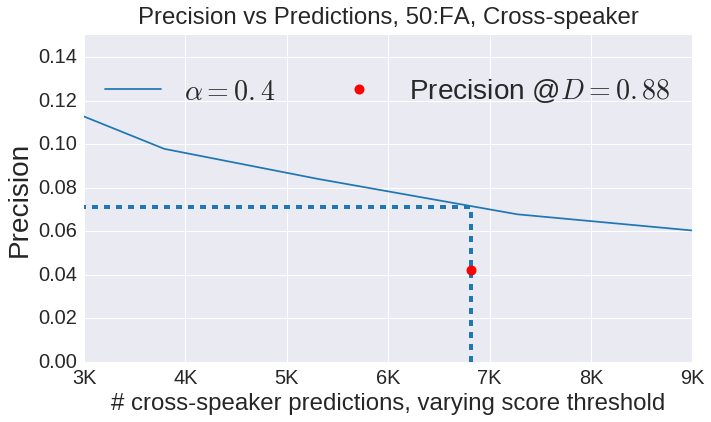

In [79]:
# Cross-Speaker

p_best, r_best, ir_best = ch.eval_precision_recall(eval_col='cnt_es_w_sim', sim_col='sim jcrd', cross_spk=True)

num_correct = []
num_predicted = []
for p, r in zip(p_best, r_best):
    correct = total_x_correct * r
    if p == 0:
        predicted = 0
    else:
        predicted = correct / p
    num_correct.append(correct)
    num_predicted.append(predicted)

num_correct = np.array(num_correct, dtype=np.int)
num_predicted = np.array(num_predicted, dtype=np.int)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.xaxis.set_major_locator(MultipleLocator(1000))
plt.xticks(rotation=0, size=24)
plt.yticks(size=20)
plt.xlim(3000, 9000)
plt.ylim(0, .15)
# ax[0].plot(num_correct, p_best)
ax.plot(num_predicted, p_best, label=r"$\alpha=0.4$", c=tableau20[0])
ax.plot(total_x_88, prec_x_88, 'or', label=r"Precision @$D=0.88$", markersize=10)
# ax.text(total_x_88, prec_x_88+.005, "baseline precision$={0:.3f}$".format(prec_x_88), size=24, ha="center", va="center",\
#                    rotation=0, color=tableau20[6])
ax.set_title('Precision vs Predictions, 50:FA, Cross-speaker', size=24, y=1.02)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95),
                  ncol=2, fancybox=True, shadow=True, fontsize=28)
plt.hlines(.071, 0, total_x_88, linestyles='--', color=tableau20[0], linewidth=4)
plt.vlines(total_x_88, 0, 0.071, linestyles='--', color=tableau20[0], linewidth=4)
ax.set_ylabel("Precision", size=28)
ax.set_xlabel("# cross-speaker predictions, varying score threshold", size=24)
count_labels = ["{0:d}K".format(x) for x in range(2,10)]
ax.set_xticklabels(count_labels, size=20)
fig.tight_layout()
fig.savefig("output/prec_pred_x_v2.pdf")
# display(zip(p_best, r_best, num_correct, num_predicted))
print(prec_x_88, total_x_88)

Interpolating similarity matrix ...
Finished interpolating similarity matrix ...
Updating data frame ...
Finished updating data frame ...
Computing precision recall, cross speaker = 0
# eval scores: 169018
# good scores: 7315
#  bad scores: 161703
Average Precision - using sim: zrt_sim
----------------------------------------
	0.12076
----------------------------------------
Accuracy - using sim: zrt_sim
----------------------------------------
	0.72704
----------------------------------------
Computing precision recall, cross speaker = 0
# eval scores: 169018
# good scores: 7315
#  bad scores: 161703
Average Precision - using sim: sim mixed
----------------------------------------
	0.35136
----------------------------------------
Accuracy - using sim: sim mixed
----------------------------------------
	0.82140
----------------------------------------


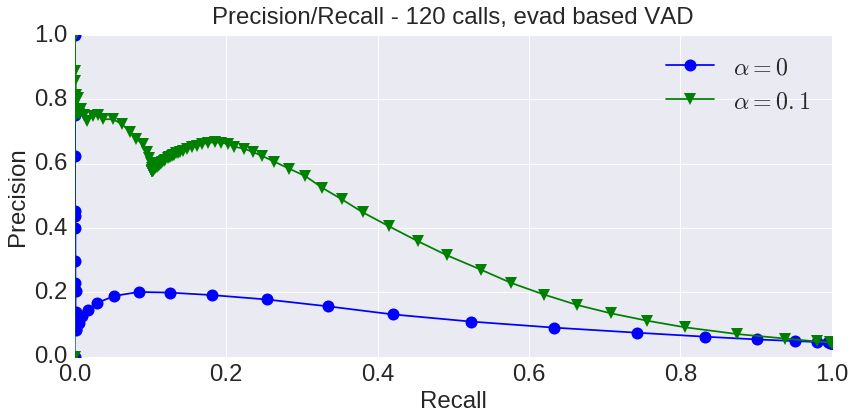

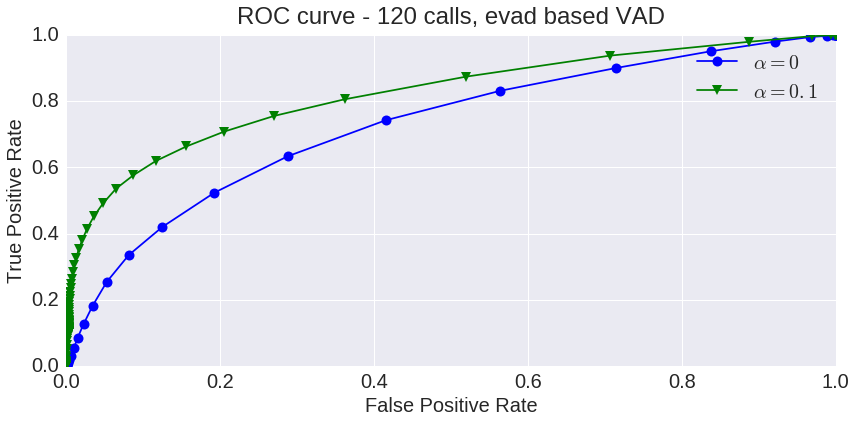

In [12]:
ch.interpolate_sim(0.4)

eval_col='cnt_es_w_sim'
# eval_col='es_w_sim'

fig_pr, fig_roc = ch.miniplot_precision_recall(eval_col=eval_col, cross_spk=False, sim_col='sim mixed')
# fig_pr.suptitle("Precision/Recall - 50 calls, energy based VAD", fontsize=24, y=1.02)
fig_pr.gca().set_title("Precision/Recall - 120 calls, evad based VAD", \
                       fontsize=24, y=1.02)
fig_pr.tight_layout()
# fiig = plt.gcf()
fig_pr.savefig("output/train_120_evad_pr.pdf")
fig_roc.gca().set_title("ROC curve - 120 calls, evad based VAD", \
                        fontsize=24, y=1.02)
fig_roc.tight_layout()
fig_roc.savefig("output/train_120_evad_roc.pdf")

## Histogram - ZRT values

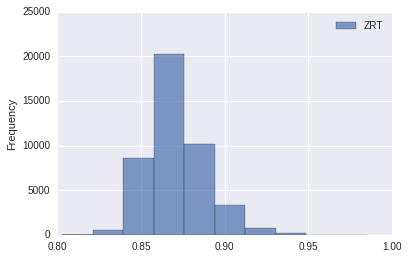

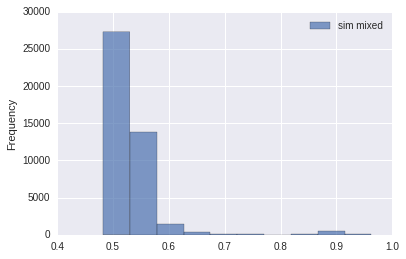

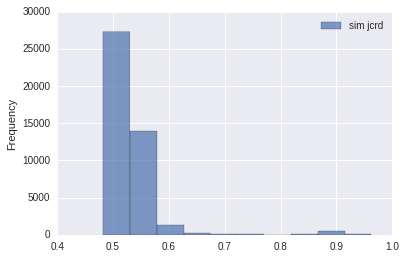

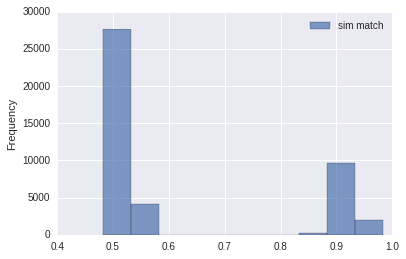

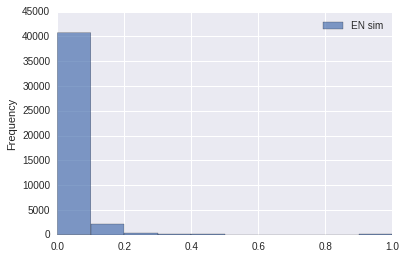

In [11]:
df_valid[['ZRT']].plot(kind='hist', alpha=0.7)
df_valid[['sim mixed']].plot(kind='hist', alpha=0.7)
df_valid[['sim jcrd']].plot(kind='hist', alpha=0.7)
df_valid[['sim match']].plot(kind='hist', alpha=0.7)
df_valid[['EN sim']].plot(kind='hist', alpha=0.7)ES cont match

In [65]:
display(df_valid['EN sim'].describe())
print(len(df_valid[(df_valid['EN sim'] >= 0.3)]))
print(len(df_valid[(df_valid['EN sim'] >= 0.3) & (df_valid['ES cont match'] == True)]))
print(len(df_valid[(df_valid['EN sim'] >= 0.3) & (df_valid['ES cont match'] == False)]))
display(len(df_valid[df_valid['ES cont match'] == 1]))
display(len(df_valid[(df_valid['EN sim'] >= 0.05) & (df_valid['ES cont match'] == 1)]))
display(len(df_valid[(df_valid['EN sim'] >= 0.05) & (df_valid['ES cont match'] == 0)]))

count   43,762.000
mean         0.025
std          0.067
min          0.000
25%          0.000
50%          0.000
75%          0.030
max          1.000
Name: EN sim, dtype: float64

335
283
52


3119

1811

6310

In [ ]:
df_valid[['dur']].plot(kind='hist', alpha=0.7, bins=200)

## Correlation between DTW and other metrics

In [ ]:
display(df_valid[['ZRT', 'EN sim']].corr())
display(df_valid[['ZRT', 'ES cont match']].corr())
display(df_valid[['EN sim', 'ES cont match']].corr())
display(df_valid[['en_w_cnt_count_sim_0', 'ES cont match']].corr())

In [110]:
cnt = defaultdict(int)
for i, pair in enumerate(ch.eval_pairs_list):
    if pair['cnt_es_w_sim'] > 0:
        cnt[0] += 1
    if pair['en_w_cnt_count_sim_0'] > 0:
        cnt[1] += 1
    if pair['en_w_cnt_hgr_sim_0'] > 0 and pair['cnt_es_w_sim'] > 0:
        cnt[2] += 1
    if pair['en_w_cnt_hgr_sim_0'] == 0 and pair['cnt_es_w_sim'] > 0:
        cnt[3] += 1
    if pair['en_w_cnt_hgr_sim_0'] > 0 and pair['cnt_es_w_sim'] == 0:
        cnt[4] += 1
    if pair['en_w_cnt_hgr_sim_0'] > 0 and pair['cnt_es_w_sim'] == 0:
        cnt[4] += 1
    if pair['en_w_cnt_hgr_sim_0'] > 0 and pair['cnt_es_w_sim'] == 0 and pair['zrt_sim'] < 0.85:
        cnt[5] += 1
    if pair['cnt_es_w_sim'] > 0 and pair['zrt_sim'] >= 0.88:
        cnt[6] += 1
    if pair['cnt_es_w_sim'] == 0 and pair['zrt_sim'] > 0.88:
        cnt[7] += 1

print(cnt)

defaultdict(<type 'int'>, {0: 3740, 1: 25359, 2: 2310, 3: 1430, 4: 46098, 5: 839, 6: 2278, 7: 46974})


# Long matches

In [139]:
print("{0:.2f}".format(66/206))
print("{0:.2f}".format(182/1330))
print("{0:.2f}".format(1064/7541))
print("{0:.2f}".format(3119/43762))

print("{0:.2f}".format(66/206))
print("{0:.2f}".format(182/1330))
print("{0:.2f}".format(1064/7541))
print("{0:.2f}".format(3119/43762))

0.32
0.14
0.14
0.07


In [60]:
long_dur_ms = 700
df_long_dur = df_valid[df_valid['dur'] >= long_dur_ms]
print("# of pairs with duration >= %dms : %d" % (long_dur_ms, len(df_long_dur)))
df_long_dur[cols_to_show].head(10)

# of pairs with duration >= 700ms : 126


,n1,n2,ZRT,ES words n1,ES words n2,ES word match,ES phone edit sim,ES cont match,EN sim,sim mixed,spk1,spk2
34,45,46,0.908,DIFíCILES POR EJEMPLO,FILóCTETES POR EJEMPLO P,1,0.857,1,0.092,0.582,1.049.007,1.049.014
3372,613,614,0.932,EN DONDE,DONDE EN DONDE sp,1,0.778,0,0.000,0.932,1.049.040,1.049.040
3376,619,620,0.913,SIMPLEMENTE EXPONGO,SIMPLEMENTE,1,0.846,1,0.069,0.575,1.049.040,1.049.062
4649,1361,1362,0.904,DOCE AL DIECIOCHO,HASTA EL DIECIOCHO,1,0.692,1,0.423,0.711,1.049.078,1.049.115
4650,1361,1372,0.895,DOCE AL DIECIOCHO,AGOSTO DIECIOCHO,1,0.769,1,0.096,0.575,1.049.078,1.049.207
4694,1401,1402,0.907,QUINCE DE SEPTIEMBRE,QUINCE DE SEPTIEMBRE,1,1.000,1,0.211,0.629,2.049.082,2.049.098
5118,1761,1762,0.933,ACTA DE BAUTISMO sil,ACTA DE BAUTISMO sil,1,1.000,1,0.119,0.607,1.049.142,1.049.152
5119,1763,1764,0.925,MI ACTA DE BAUTISMO,MI ACTA DE BAUTISMO,1,1.000,1,0.196,0.633,1.049.142,1.049.154
5155,1835,1836,0.931,ACTA DE BAUTISMO sil,ACTA DE BAUTISMO sil,1,0.929,1,0.394,0.716,1.049.152,1.049.154
5215,1939,1940,0.922,DE CONFIRMACIóN,Y CONFIRMACIóN,1,0.846,1,0.173,0.622,2.049.157,2.049.159


In [70]:
df_valid.ix[15944]

chid1                                      1
chid2                                      1
cnt_es_w_check                          True
ES cont match                              0
dur                                      530
en_w_cnt_count_sim_0                       0
EN sim                                 0.000
en_w_cnt_jcrd_sim_0                    0.000
en_w_count_sim_0                           0
en_w_hgr_sim_0                         0.000
en_w_jcrd_sim_0                        0.000
ES phone edit sim                      0.600
ES words n1             ENTONCES YA NO PUEDE
ES words n2                       BUENO PUES
ES word match                              0
n1                                     33935
n2                                     33936
no_mtch                                False
sil_major                              False
sil_only                               False
sil_sp                                 False
uid1                                 061.134
uid2      

In [212]:
display(Audio(ch.play_pair_wav(5118)))

Playing evaluation pair id: 5118
Pair text details
+---------+----------------------+-----------------------------------------------+
| node id |    ES transcript     |                 EN translation                |
+---------+----------------------+-----------------------------------------------+
|   1761  | ACTA DE BAUTISMO sil |     to tell them to send me my baptism act    |
+---------+----------------------+-----------------------------------------------+
|   1762  | ACTA DE BAUTISMO sil | we are going to need the sacrament of baptism |
|         |                      |                     paper                     |
+---------+----------------------+-----------------------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type             | Similarity Value |
+----------------------------------------+------------------+
|                  ZRT                   |      0.933       |
+-----------------

In [213]:
nodes_table = PrettyTable(["Node id", "Speech file", \
                           "Start time(ms)", \
                           "End time(ms)"])
transcripts_table = PrettyTable(["Node id", "ES words", \
                           "ES content words"])

scores_table = PrettyTable(["Pair id", "Node 1", "Node 2", "DTW score", "ES content word match"])


# for i in range(1,5)+[27, 28, 61, 62, 64, 1761,1762]:
#     nodes_table.add_row([i, ch.node_dict[i].wav_fil+".wav", ch.node_dict[i].start, \
#                         ch.node_dict[i].end])
#     #print((' '.join(ch.node_dict[i].es_cnt_words).decode('utf-8')))
#     es_w = (' '.join(ch.node_dict[i].es_words).decode('utf-8'))
#     if ch.node_dict[i].es_cnt_words:
#         es_cnt_w = (' '.join(ch.node_dict[i].es_cnt_words).decode('utf-8')).strip()
#     else:
#         es_cnt_w = '---'
#     #print(i, set(ch.node_dict[i].es_cnt_words) - set(['sil', 'sp']))
#     es_w = es_w.replace('sil', '').replace('sp', '')
#     es_cnt_w = es_cnt_w.replace('sil', '').replace('sp', '')
#     transcripts_table.add_row([i, es_w, es_cnt_w])

# found = 0
# for i, pair in enumerate(ch.eval_pairs_list):
#     if found == 10:
#         break
#     if pair['cnt_es_w_sim'] > 0 or i<=2:
#         scores_table.add_row([i, pair['n1'], pair['n2'], pair['zrt_sim'], pair['cnt_es_w_sim']])
#         found += 1

# print(nodes_table)
# print(transcripts_table)
# print(scores_table)
# #print(' '.join(ch.node_dict[2].es_words))


# display(ch.eval_pairs_list[1])
# found = 0
# for i, pair in enumerate(ch.eval_pairs_list):
#     if pair['zrt_sim'] >= 0.88 and len(pair['es_w_n1'].split()) >= 1 \
#     and pair['en_w_hgr_sim_0'] == 0 \
#     and pair['sil_only'] == False \
#     and pair['uid1'] != pair['uid2']:
#         print(i, pair['n1'], pair['n2'], \
#               pair['es_w_n1'].decode('utf-8'), pair['es_w_n2'].decode('utf-8'),\
#              pair['cnt_es_w_sim'])
#         found += 1
#         if found == 5:
#             break
# print(found)


# found = 0
# for i, pair in enumerate(ch.eval_pairs_list):
#     if pair['dur'] >= 100 \
#     and pair['en_w_hgr_sim_0'] == 0 and pair['sil_only'] == True:
#         print(i, pair['n1'], pair['n2'], \
#               pair['es_w_n1'].decode('utf-8'), pair['es_w_n2'].decode('utf-8'),\
#              pair['cnt_es_w_sim'])
#         found += 1
#         if found == 5:
#             break
# print(found)

In [38]:
print(ch.eval_pairs_list[0].keys())

['es_p_sim', 'no_mtch', 'es_w_n1', 'es_w_n2', 'sil_sp', 'uid2', 'uid1', 'en_w_jcrd_sim_0', 'cnt_es_w_check', 'dur', 'en_w_cnt_jcrd_sim_0', 'en_w_cnt_hgr_sim_0', 'en_w_hgr_sim_0', 'n1', 'sil_major', 'chid1', 'en_w_count_sim_0', 'zrt_sim', 'cnt_es_w_sim', 'sil_only', 'en_w_cnt_count_sim_0', 'chid2', 'n2', 'es_w_sim']


In [64]:
valid_pairs = 0

for i, pair in enumerate(ch.eval_pairs_list):
    if pair['cnt_es_w_sim'] == 1 and \
    pair['sil_major'] == False and pair['no_mtch'] == False and pair['sil_only'] == False:
        valid_pairs += 1
print(i, valid_pairs)

valid_pairs = 0
for i, pair in enumerate(ch.eval_pairs_list):
    if pair['cnt_es_w_sim'] == 1 and pair['en_w_cnt_jcrd_sim_0'] == 0 and \
    pair['sil_major'] == False and pair['no_mtch'] == False and pair['sil_only'] == False:
        valid_pairs += 1
print(i, valid_pairs)

valid_pairs = 0
for i, pair in enumerate(ch.eval_pairs_list):
    if pair['cnt_es_w_sim'] == 1 and pair['en_w_cnt_jcrd_sim_0'] >= 0.1 and \
    pair['sil_major'] == False and pair['no_mtch'] == False and pair['sil_only'] == False:
        valid_pairs += 1
print(i, valid_pairs)

valid_pairs = 0
for i, pair in enumerate(ch.eval_pairs_list):
    if pair['cnt_es_w_sim'] == False and pair['en_w_cnt_jcrd_sim_0'] >= 0.1 and \
    pair['sil_major'] == False and pair['no_mtch'] == False and pair['sil_only'] == False:
        valid_pairs += 1
print(i, valid_pairs)

125084 3119
125084 1142
125084 1251
125084 1619


In [222]:
nodes_list = []
valid_pairs = 0
for i, pair in enumerate(ch.eval_pairs_list):
    if pair['no_mtch'] == 0 and pair['sil_only'] == 0:
        nodes_list.append(pair['n1'])
        nodes_list.append(pair['n2'])
        valid_pairs += 1
print(i, valid_pairs)

n = len(nodes_list)
print('Number of nodes: %d' % n)
print(len(set(nodes_list)))
print(nodes_list)
file_node_regions = {}
print(ch.node_dict[nodes_list[0]])
print(ch.node_dict[nodes_list[0]].wav_fil)
for n in nodes_list:
    if ch.node_dict[n].wav_fil not in file_node_regions:
        file_node_regions[ch.node_dict[n].wav_fil] = []

print(len(file_node_regions))

for n in set(nodes_list):
    node = ch.node_dict[n]
    file_node_regions[node.wav_fil].extend(range(node.start, node.end+1))

total_dur = 0
total_nonolap_dur = 0
for fil in file_node_regions:
    total_dur += len(file_node_regions[fil])
    total_nonolap_dur += len(set(file_node_regions[fil]))

print(total_dur*10/1000/3600)
print(total_nonolap_dur*10/1000/3600)

# olap_vals = []
# for i in xrange(n-1):
#     if i % 1000 == 0:
#         print(i, sep=', ', end=', ')
#     for j in xrange(i+1,n):
#         olap_vals.append(ch.calc_node_overlap(nodes_list[i],nodes_list[j]))
    

19437 8153
Number of nodes: 16306
11427
049.003 356 411
049.003
2076
1.80724444444
1.01268888889


In [311]:
%run speechutils.py
ch_20_avad = callhome_eval_init("config.json", fast=False, alpha=.1)
df_zrt_20_avad, cols_to_show = ch_20_avad.gen_zrt_df()

../../ZRTools/exp/callhome_train_20/matches/config0.80-0.80-0.80-50/master_graph.nodes
Loading prep state dictionary ...
Finished loading prep state dictionary ...
Finished ...
Finished - reading nodes ...
Processing line: 1
Finished - reading edges ...
Removing duplicates in pairs list
Set length: 18472 and List length: 43061
Generating vocabulary of English words ... 
Finished vocab ...
Generating initial belief over English translations
Processed 1 nodes
Generating similarity between nodes based on English translations ...
Finished generating similarity ...
Generating similarity between nodes based on English translations ...
Finished generating similarity ...
Processing line: 1
Processing line: 3001
Processing line: 6001
Processing line: 9001
Processing line: 12001
Processing line: 15001
Processing line: 18001
Total matches: 18472
matches with missing transcriptions: 6066
matches with only sil, sp: 8646
Finished - evaluating 18472 pairs ...
Setting up eval data frame
Finished ...
S

In [323]:
nodes_list = []
valid_pairs = 0
for i, pair in enumerate(ch_20_avad.eval_pairs_list):
    n1 = ch_20_avad.node_dict[pair['n1']]
    n2 = ch_20_avad.node_dict[pair['n2']]
    esw1 = n1.es_words
    esw2 = n2.es_words
    if 'sil' not in esw1 and 'sp' not in esw1 and 'sil' not in esw2 and 'sp' not in esw2 and \
    pair['no_mtch'] == 0 and pair['sil_only'] == 0 and len(esw1) > 0 and len(esw2)>0:
        nodes_list.append(pair['n1'])
        nodes_list.append(pair['n2'])
        valid_pairs += 1
print(i, valid_pairs)

nodes_list = []
valid_pairs = 0
for i, pair in enumerate(ch.eval_pairs_list):
    n1 = ch.node_dict[pair['n1']]
    n2 = ch.node_dict[pair['n2']]
    esw1 = n1.es_words
    esw2 = n2.es_words
    if 'sil' not in esw1 and 'sp' not in esw1 and 'sil' not in esw2 and 'sp' not in esw2 and \
    pair['no_mtch'] == 0 and pair['sil_only'] == 0:
        nodes_list.append(pair['n1'])
        nodes_list.append(pair['n2'])
        valid_pairs += 1
print(i, valid_pairs)

print(len([pair for pair in ch_20_avad.eval_pairs_list if not pair['no_mtch'] and not pair['sil_only']]))
print(len([pair for pair in ch_20_avad.eval_pairs_list if not pair['sil_sp']]))
print(len([pair for pair in ch.eval_pairs_list if not pair['no_mtch'] and not pair['sil_only']]))
print(len([pair for pair in ch.eval_pairs_list if not pair['sil_sp']]))

# print(len([pair for pair in ch_20_avad.eval_pairs_list if pair['sil_only'] == 0]))

18471 4452
1411 1063
9826
4452
1355
1063


In [303]:
ch.have_words_in_common([],[])

0

In [313]:
dur_ms = 0
dur_50_evad = []
print(len(ch.b_vad_files))
print(ch.b_vad_files[0])
for fil in ch.b_vad_files:
    with open(fil, "r") as in_f:
        for line in in_f:
            line_items = map(int, line.strip().split())
            dur_ms += ((line_items[1] - line_items[0]) * 10)
            dur_50_evad.append(((line_items[1] - line_items[0]) * 10))
print(dur_ms/1000/3600)
print(np.mean(dur_50_evad))
print(len(dur_50_evad))

total_dur = 0; total_dur_trns = 0
dur_20_avad = []
print(len(ch_20_avad.b_base_name))
# Get duration from VAD files
for key in sorted(ch_20_avad.b_base_name):
    # Get duration from non sil, sp parts in transcriptions
    for t in ch_20_avad.es_words_dict[key]:
        #dur_val = (((t.end-t.start)*10) if t.word not in ['sil','sp'] else 0)
        dur_val = (((t.end-t.start)*10) if t.word not in ['sil'] else 0)
        if dur_val > 0:
            total_dur_trns += dur_val
            dur_20_avad.append(dur_val)
        

    # Get duration from utterance level VAD    
    total_dur += ((ch_20_avad.file_info_dict[key].vad.end - ch_20_avad.file_info_dict[key].vad.start)*10)
print(total_dur_trns/1000/3600)
print(total_dur/1000/3600)
print(np.mean(dur_20_avad))
print(len(dur_20_avad))

9165
../../corpora/callhome_es/out/049.001.evad
2.29908888889
666.027198841
12427
3716
2.81449166667
3.33863611111
256.816211695
39453


In [159]:
olap_vals = np.array(olap_vals, dtype=np.float)
print("\nMean: %0.3f" % np.mean(olap_vals))


Mean: 0.091


In [ ]:
cPickle.dump(olap_vals, open('olap_20_avad_vals.np', "wb"))

In [ ]:
olap_50_evad_mean = 0.097
olap_20_avad_mean = 0.077

In [ ]:
%run viewutils.ipynb
display_pair_and_plot_dtw(963, tosave=False, \
                          offset_1=(0,None), \
                          offset_2=(0,None), \
                          n_labels=("Pair 5", "segment 9", "segment 10"),phones=False)

# %run viewutils.ipynb
# display_pair_and_plot_dtw(15, tosave=False, \
#                           offset_1=(55,61), \
#                           offset_2=(150,156), \
#                           n_labels=("Pair 5", "segment 9", "segment 10"))

print(' '.join(ch.en_cnt_words_dict[ch.node_dict[180].wav_fil]))
print(' '.join(ch.en_cnt_words_dict[ch.node_dict[1674].wav_fil]))
print(' '.join(ch.node_dict[180].es_cnt_words))
print(' '.join(ch.node_dict[1674].es_cnt_words))

In [ ]:
display(Audio(ch.play_pair_wav(15, detail=True)))

In [ ]:
display(Audio(ch.play_node_wav(20)))
# display(Audio('../../corpora/callhome_es/out/lala.wav'))
# display(Audio(ch.play_node_source_wav(12)))
for i, val in enumerate(ch.es_words_dict['050.048']):
    print(i, val.start)

In [ ]:
display(Audio(ch.play_pair_wav(34)))
display(Audio(ch.play_pair_wav(5119)))

In [ ]:
display(ch.play_node_wav(619))
display(ch.play_node_wav(620))
display(ch.play_node_wav(45))
display(ch.play_node_wav(46))

node_1_file = ch.play_node_wav(1761)
node_2_file = ch.play_node_wav(1762)
display(node_1_file)
display(node_2_file)
# display(ch.play_node_source_wav(76605))

In [ ]:
plot_dtw(node_1_file, node_2_file)

In [ ]:
%run viewutils.ipynb
node_id = 1761

node_info = ch.node_dict[node_id]
wav_file = node_info.wav_fil
target_file = ch.file_info_dict[wav_file].target_file+".wav"
es_words = ch.es_words_dict[wav_file]
plot_name = "output/bautismo_1761.pdf"

plot_specgram_words(target_file, es_words, plot_name, offset=(0,10))

print(ch.en_words_dict[wav_file])

In [ ]:
node_id = 1762

node_info = ch.node_dict[node_id]
wav_file = node_info.wav_fil
target_file = ch.file_info_dict[wav_file].target_file+".wav"
es_words = ch.es_words_dict[wav_file]
plot_name = "output/bautismo_1762.pdf"

plot_specgram_words(target_file, es_words, plot_name, offset=(0,12))

print("English translation:\n%s" % ' '.join(ch.en_words_dict[wav_file]))

In [ ]:
2680-1710

In [ ]:
display(Audio(ch.play_pair_wav(5118)))

In [11]:
# %run viewutils.ipynb

# node_1 = ch.node_dict[1761]
# node_2 = ch.node_dict[1762]

# wav_1 = ch.file_info_dict[node_1.wav_fil].target_file+".wav"
# wav_2 = ch.file_info_dict[node_2.wav_fil].target_file+".wav"

# es_words_1 = ch.es_words_dict[node_1.wav_fil]
# es_words_2 = ch.es_words_dict[node_2.wav_fil]
# plot_name = "output/dtw_pair_1761_1762.pdf"
# # print(wav_1, wav_2)
# # print(es_words_1, es_words_2)
# wav_1_time = (node_1.start, node_1.end)
# wav_2_time = (node_2.start, node_2.end)
# plot_dtw(wav_1, wav_2, es_words_1, es_words_2, \
#          wav_1_time, wav_2_time, plot_name)

In [103]:
%run viewutils.ipynb

In [112]:
tosave=True

Playing evaluation pair id: 5118
Pair text details
+---------+----------------------+-----------------------------------------------+
| node id |    ES transcript     |                 EN translation                |
+---------+----------------------+-----------------------------------------------+
|   1761  | ACTA DE BAUTISMO sil |     to tell them to send me my baptism act    |
+---------+----------------------+-----------------------------------------------+
|   1762  | ACTA DE BAUTISMO sil | we are going to need the sacrament of baptism |
|         |                      |                     paper                     |
+---------+----------------------+-----------------------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type             | Similarity Value |
+----------------------------------------+------------------+
|                  ZRT                   |      0.933       |
+-----------------

MI ACTA DE BAUTISMO sil
DEL ACTA DE BAUTISMO sil
DTW distance: 54.530782
Saving: output/5118.pdf
tell send baptism act
going need sacrament baptism paper
ACTA BAUTISMO sil
ACTA BAUTISMO sil
set(['baptism'])
going~,sacrament~,send~,paper~,act~,need~,baptism~,tell
0.125


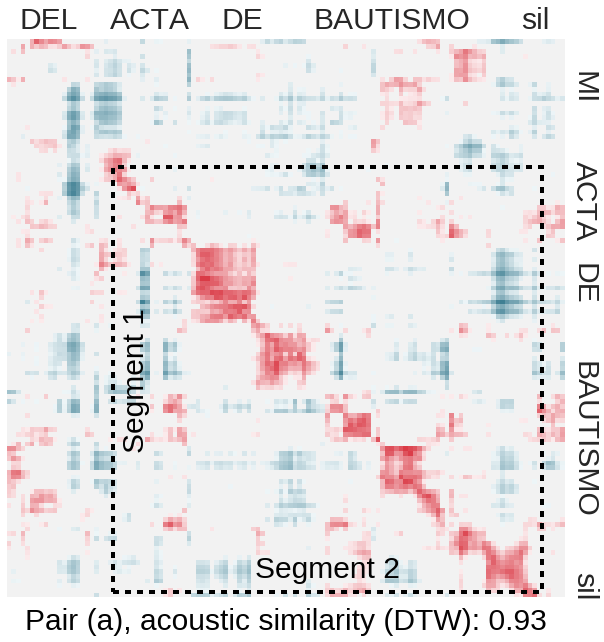

In [113]:
%run viewutils.ipynb
display_pair_and_plot_dtw(5118, tosave=tosave, \
                          offset_1=(6,None), \
                          offset_2=(8,None), \
                          n_labels=("Pair (a)", "Segment 1", "Segment 2"))

print(' '.join(ch.en_cnt_words_dict[ch.node_dict[1761].wav_fil]))
print(' '.join(ch.en_cnt_words_dict[ch.node_dict[1762].wav_fil]))
print(' '.join(ch.node_dict[1761].es_cnt_words))
print(' '.join(ch.node_dict[1762].es_cnt_words))
num = set(ch.en_cnt_words_dict[ch.node_dict[1761].wav_fil]) & set((ch.en_cnt_words_dict[ch.node_dict[1762].wav_fil]))
print(num)
den = set(ch.en_cnt_words_dict[ch.node_dict[1761].wav_fil]) | \
      set((ch.en_cnt_words_dict[ch.node_dict[1762].wav_fil]))
den = list(den)
print('~,'.join(den))
print(len(num) / len(den))

Playing evaluation pair id: 15944
Pair text details
+---------+----------------------+----------------------------------+
| node id |    ES transcript     |          EN translation          |
+---------+----------------------+----------------------------------+
|  33935  | ENTONCES YA NO PUEDE | not now now then he cant anymore |
+---------+----------------------+----------------------------------+
|  33936  |      BUENO PUES      |   yes well its good well yeah    |
+---------+----------------------+----------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type             | Similarity Value |
+----------------------------------------+------------------+
|                  ZRT                   |      0.881       |
+----------------------------------------+------------------+
|         ES content* word match         |        0         |
+----------------------------------------+------------------+
|    

ENTONCES YA NO PUEDE
BUENO PUES
DTW distance: 79.380304
Saving: output/15944.pdf
cant anymore
yes well good well yeah
ENTONCES PUEDE
BUENO PUES


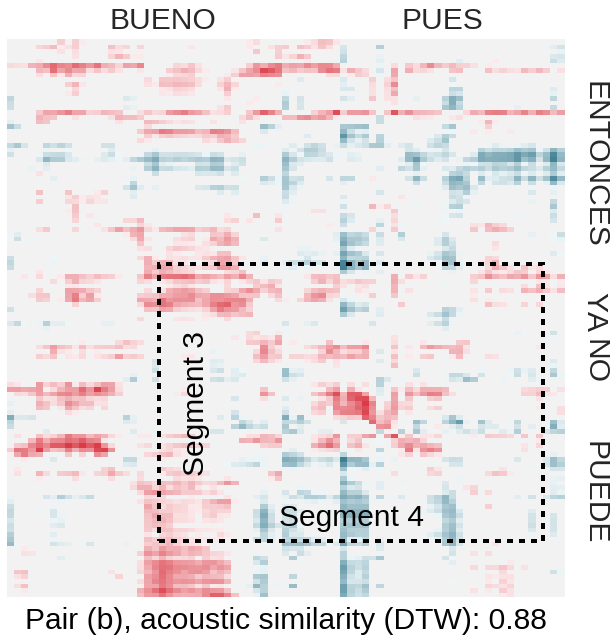

In [114]:
display_pair_and_plot_dtw(15944, tosave=tosave, \
                          offset_1=(4,-2), \
                          offset_2=(3,-2), \
                          n_labels=("Pair (b)", "Segment 3", "Segment 4"))

print(' '.join(ch.en_cnt_words_dict[ch.node_dict[33935].wav_fil]))
print(' '.join(ch.en_cnt_words_dict[ch.node_dict[33936].wav_fil]))
print(' '.join(ch.node_dict[33935].es_cnt_words))
print(' '.join(ch.node_dict[33936].es_cnt_words))

In [80]:
print(ch.en_w_cnt_belief[44099])
print(' & '.join([ch.i2w[w] for w in ch.en_w_cnt_belief[44099]]))
print(' & '.join(["{0:.2f}".format(b) for b in ch.en_w_cnt_belief[44099].values()]))

print([ch.i2w[w] for w in ch.en_w_cnt_belief[44100]])
print(["{0:.2f}".format(b) for b in ch.en_w_cnt_belief[44100].values()])

{1504: 0.16666666666666666, 1329: 0.16666666666666666, 730: 0.16666666666666666, 1632: 0.16666666666666666, 1455: 0.3333333333333333}
okay & thousand & address & hundred & two
0.17 & 0.17 & 0.17 & 0.17 & 0.33
['hundred', 'thousand', 'two']
['0.25', '0.25', '0.50']


Playing evaluation pair id: 16848
Pair text details
+---------+----------------+------------------------------------------------+
| node id | ES transcript  |                 EN translation                 |
+---------+----------------+------------------------------------------------+
|  44099  | MIL DOSCIENTOS | okay this the address two thousand two hundred |
+---------+----------------+------------------------------------------------+
|  44100  | MIL DOSCIENTOS |            two thousand two hundred            |
+---------+----------------+------------------------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type             | Similarity Value |
+----------------------------------------+------------------+
|                  ZRT                   |      0.864       |
+----------------------------------------+------------------+
|         ES content* word match         |        1         |
+----------

DOS MIL DOSCIENTOS
DOS MIL DOSCIENTOS
DTW distance: 65.903506
Saving: output/16848.pdf
('MIL', 'DOSCIENTOS')
('MIL', 'DOSCIENTOS')
okay address two thousand two hundred
two thousand two hundred
MIL DOSCIENTOS
MIL DOSCIENTOS


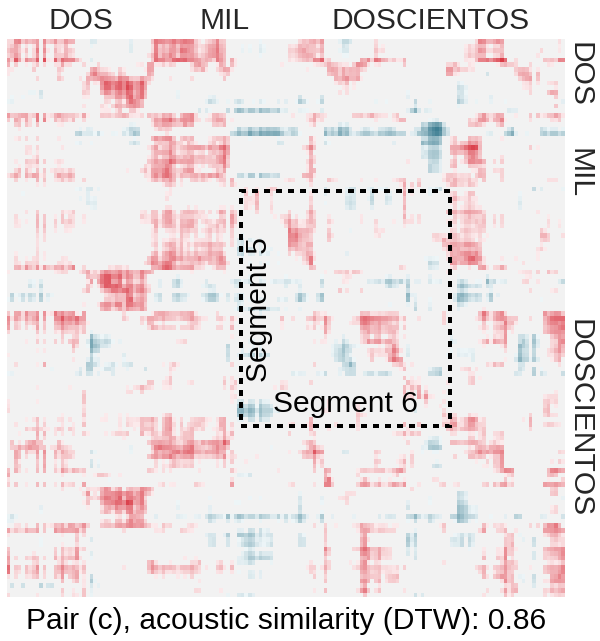

In [115]:
display_pair_and_plot_dtw(16848, tosave=tosave, \
                          offset_1=(6,9), \
                          offset_2=(1,4), \
                          n_labels=("Pair (c)", "Segment 5", "Segment 6"))

print(ch.node_dict[44099].es_cnt_words)
print(ch.node_dict[44100].es_cnt_words)
print(' '.join(ch.en_cnt_words_dict[ch.node_dict[44099].wav_fil]))
print(' '.join(ch.en_cnt_words_dict[ch.node_dict[44100].wav_fil]))
print(' '.join(ch.node_dict[44099].es_cnt_words))
print(' '.join(ch.node_dict[44100].es_cnt_words))

In [ ]:
display_pair_and_plot_dtw(19326, tosave=tosave, \
                          offset_1=(0,3), \
                          offset_2=(0,3), \
                          n_labels=("pair 4", "node 7", "node 8"))

## Callhome 50, evad

In [ ]:
display_pair_and_plot_dtw(817, tosave=False)

### High phoneme score

In [ ]:
df_phone_score_hi = df_valid[(df_valid['ES phone edit sim'] >= 0.6) \
                            & (df_valid['EN sim'] == 0)]
print("Pairs with high phoneme similarity score: %d" % len(df_phone_score_hi))

f, ax = plt.subplots(figsize=(10, 6))
df_phone_score_hi[['ZRT']].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score >= 0.5', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

In [ ]:
df_phone_score_hi[cols_to_show].head(5)

In [ ]:
display(Audio(ch.play_pair_wav(75)))

## Low phoneme score

In [ ]:
df_phone_score_0 = df_valid[(df_valid['ES phone edit sim'] == 0)]
print("Pairs with 0 phoneme similarity score: %d" % len(df_phone_score_0))

f, ax = plt.subplots(figsize=(10, 6))
df_phone_score_0[['ZRT']].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score = 0', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

** Analysis:** The plot shows a lot of high DTW score pairs where there is no match in the phonemes

In [ ]:
df_phone_score_0_high_dtw = df_phone_score_0[df_phone_score_0['ZRT'] > 0.87]
print("Pairs with high DTW and 0 phoneme similarity score: %d" % len(df_phone_score_0_high_dtw))

display(df_phone_score_0_high_dtw[cols_to_show].head(3))
# ch.play_pair_wav(28)

In [ ]:
df_phone_score_0_en_score_0 = df_phone_score_0[df_phone_score_0['EN sim'] == 0]
print("Pairs with 0 phoneme score and 0 EN sim: %d" % len(df_phone_score_0_en_score_0))
# display(df_phone_score_0_en_score_0[cols_to_show][df_phone_score_0_en_score_0['ZRT'] < 0.82].head(3))
display(df_phone_score_0_en_score_0[cols_to_show].head(3))

df_phone_score_0_high_dtw_en_score_0 = df_phone_score_0_high_dtw[df_phone_score_0_high_dtw['EN sim'] == 0]
print("Pairs with high DTW and 0 phoneme score and 0 EN sim: %d" % len(df_phone_score_0_high_dtw_en_score_0))
display(df_phone_score_0_high_dtw_en_score_0[cols_to_show].head(3))

In [ ]:
# display(ch.play_pair_wav(594, detail=True))
display(ch.play_pair_wav(52, detail=False))
# display(ch.play_node_source_wav(131))

In [ ]:
ch.file_info_dict["049.156"].source_file

In [ ]:
# !soxi ../../corpora/callhome_es/out/006.183.wav
# !play ../../corpora/callhome_es/out/006.183.wav trim 1.24
# IPython.display.Audio("../../corpora/callhome_es/out/tmp/sp_0731_1.wav")

### Conclusion

**Pairs with high DTW and 0 phoneme and 0 EN word similarity indicate transcription errors or coding errors**


**Need to investigate**

### High Phoneme similarity

In [ ]:
# df_phone_score_hi = df_valid[(df_valid['ES phone edit sim'] >= 0.5)]
# print("Pairs with high phoneme similarity score: %d" % len(df_phone_score_hi))

f, ax = plt.subplots(figsize=(10, 6))
df_valid['ZRT'].hist(ax=ax, alpha=0.3)
df_phone_score_hi['ZRT'].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score > 0.5', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

In [ ]:
df_phone_score_hi_en_score_0 = df_phone_score_hi[(df_phone_score_hi['EN sim'] == 0) & \
                                                (df_phone_score_hi['spk1'] != df_phone_score_hi['spk2'])]
print("Pairs with high phoneme score and 0 EN sim: %d" % len(df_phone_score_hi_en_score_0))

df_phone_score_hi_en_score_0[cols_to_show].head(5)

In [ ]:
ch.play_pair_wav(70)

## High DTW score, Low EN translation similarity

These are expected to be phonetically similary but semantically different pairs.

**Label Spreading** should help **lower** the DTW score

In [ ]:
df_valid['ZRT'][(df_valid['EN sim'] == 0)].hist()
print(len(df_valid['ZRT'][(df_valid['EN sim'] == 0)]))

In [ ]:
df_high_dtw_0_en = df_valid[(df_valid['ZRT'] > 0.87) \
                            & (df_valid['EN sim'] >= 0.2) & \
                            (df_valid['spk1'] != df_valid['spk2'])]

In [ ]:
print("Pairs with high DTW annd 0 EN sim: %d" % len(df_high_dtw_0_en))
df_high_dtw_0_en[cols_to_show].head(5)

In [ ]:
display(Audio(ch.play_pair_wav(105, detail=True)))

In [ ]:
# !play ../../corpora/callhome_es/out/001.202.wav trim .75 =.99

## Low DTW score, High EN translation similarity

These are expected to be semantically similar but phonetically not very similar.

**Label Spreading** should help **increase** the DTW score

In [ ]:
df_valid['ZRT'][(df_valid['EN sim'] >= 0.2)].hist()

In [ ]:
df_low_dtw_high_en = df_valid[(df_valid['ZRT'] < 0.88) & (df_valid['EN sim'] >= 0.2)]

In [ ]:
print("Pairs with high DTW annd 0 EN sim: %d" % len(df_low_dtw_high_en))
df_low_dtw_high_en[cols_to_show].tail()

In [ ]:
display(Audio(ch.play_pair_wav(19326, detail=True)))

## Precision / Recall

In [ ]:
df_valid[cols_to_show].head()

In [134]:
alpha = 0.4
ch.interpolate_sim(alpha)
df_zrt, cols_to_show = ch.gen_zrt_df()

Interpolating similarity matrix ...
Finished interpolating similarity matrix ...
Updating data frame ...
Finished updating data frame ...


In [48]:
ch.eval_precision_recall()

Computing precision recall, cross speaker = 0
# eval scores: 57979
# good scores: 3740
#  bad scores: 54239
Average Precision - using sim: zrt_sim
----------------------------------------
	0.14489
----------------------------------------
Accuracy - using sim: zrt_sim
----------------------------------------
	0.50000
----------------------------------------


(array([ 0.06450611,  0.06450611,  0.06451056,  0.06451279,  0.06451724,
         0.0645306 ,  0.06454564,  0.06463661,  0.06489532,  0.06560875,
         0.06743253,  0.07082479,  0.07691468,  0.08688902,  0.10106193,
         0.1173727 ,  0.13657381,  0.15609056,  0.17412441,  0.18560372,
         0.18935562,  0.18793212,  0.18469896,  0.16192412,  0.14271152,
         0.12162162,  0.0989011 ,  0.07534247,  0.06914894,  0.08130081,
         0.10344828,  0.15517241,  0.20930233,  0.29032258,  0.33333333,
         0.39130435,  0.47368421,  0.57142857,  0.66666667,  0.55555556,
         0.55555556,  0.        ]),
 array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  0.99973262,  0.99946524,  0.99786096,  0.99491979,
         0.98877005,  0.97005348,  0.94144385,  0.89786096,  0.83208556,
         0.73342246,  0.63181818,  0.52352941,  0.42139037,  0.32058824,
         0.2302139 ,  0.15989305,  0.10909091,  0.06390374,  0.03743316,
         0.0216

In [ ]:
ch.eval_precision_recall(sim_col='sim mixed')

Computing precision recall, cross speaker = 0
# eval scores: 169018
# good scores: 7315
#  bad scores: 161703
Average Precision - using sim: zrt_sim
----------------------------------------
	0.12076
----------------------------------------
Accuracy - using sim: zrt_sim
----------------------------------------
	0.72704
----------------------------------------
Computing precision recall, cross speaker = 0
# eval scores: 169018
# good scores: 7315
#  bad scores: 161703
Average Precision - using sim: sim jcrd
----------------------------------------
	0.35455
----------------------------------------
Accuracy - using sim: sim jcrd
----------------------------------------
	0.82116
----------------------------------------


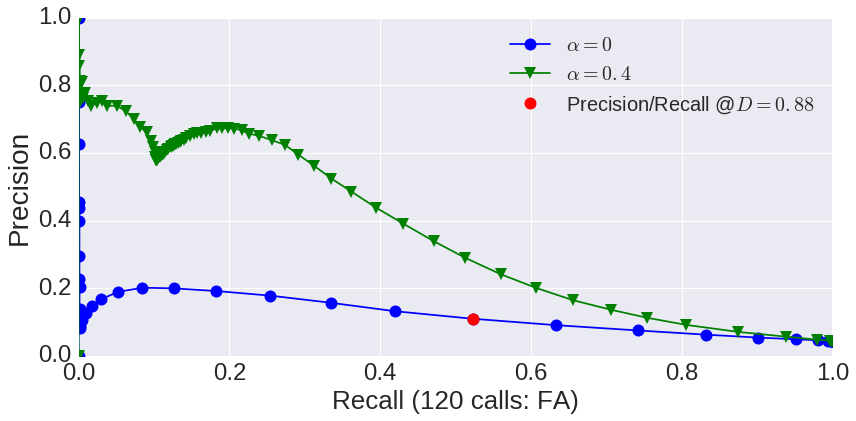

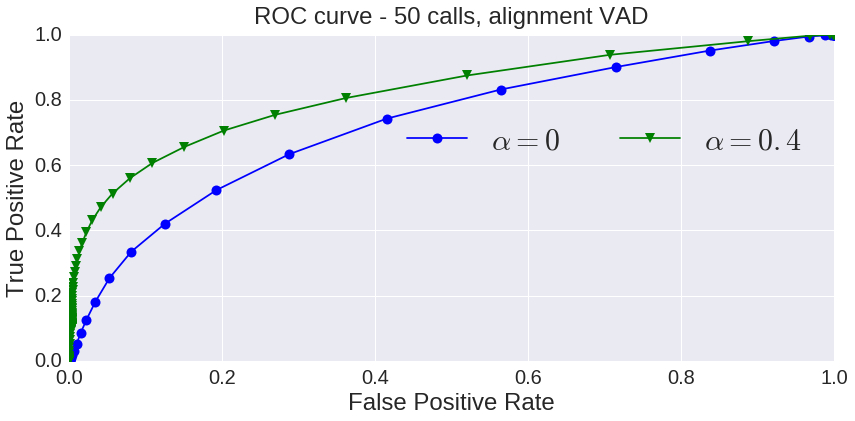

In [12]:
eval_col='cnt_es_w_sim'
# eval_col='es_w_sim'

fig_pr, fig_roc = ch.miniplot_precision_recall(eval_col=eval_col, cross_spk=False, alpha=0.4, sim_col='sim jcrd')
# fig_pr.gca().set_title("Precision/Recall - 50 calls, FA", \
#                        fontsize=28, y=1.02)
fig_pr.gca().legend(loc='upper center', bbox_to_anchor=(0.7, 0.8),
                  ncol=2, fancybox=True, shadow=True, fontsize=35)
fig_pr.gca().set_ylabel("Precision", fontsize=28)
fig_pr.gca().set_xlabel("Recall (120 calls: FA)", fontsize=26)
fig_pr.gca().plot(recall_88, prec_88, 'or', label=r"Precision/Recall @$D=0.88$", markersize=12)
fig_pr.gca().legend(fontsize=20)
fig_pr.tight_layout()
fig_pr.savefig("output/train_120_avad_pr.pdf")

fig_roc.gca().set_title("ROC curve - 50 calls, alignment VAD", \
                        fontsize=24, y=1.02)
fig_roc.gca().legend(loc='upper center', bbox_to_anchor=(0.7, 0.8),
                  ncol=2, fancybox=True, shadow=True, fontsize=30)
fig_roc.gca().set_ylabel("True Positive Rate", fontsize=24)
fig_roc.gca().set_xlabel("False Positive Rate", fontsize=24)
fig_roc.tight_layout()
fig_roc.savefig("output/train_120_avad_roc.pdf")

## Cross-utterance matches

In [ ]:
set_speakers_calls = set()
spk1_ids = [s.rsplit('.', 1)[0] for s in df_valid['spk1'].values]
spk2_ids = [s.rsplit('.', 1)[0] for s in df_valid['spk2'].values]
set_speakers_calls |= set(spk1_ids)
set_speakers_calls |= set(spk2_ids)

num_speakers = len(set_speakers_calls)
cross_spk_counts = np.zeros((num_speakers, num_speakers), dtype=np.int)
label2i = {k:i for i, k in enumerate(set_speakers_calls)}
i2label = {i:k for i, k in enumerate(set_speakers_calls)}

lol = 0
for spk1, spk2 in zip(spk1_ids, spk2_ids):
    if spk1 != spk2:
        lol += 1
        cross_spk_counts[max(label2i[spk1], label2i[spk2]), min(label2i[spk1], label2i[spk2])] += 1
        cross_spk_counts[min(label2i[spk1], label2i[spk2]), max(label2i[spk1], label2i[spk2])] += 1
    else:
        cross_spk_counts[label2i[spk1], label2i[spk2]] += 1
        pass

print("Total speakers: %d" % num_speakers)
print(lol)

In [ ]:
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

with sns.axes_style("white"):
    ax = sns.heatmap(cross_spk_counts, square=True, annot=False, \
                 fmt="d", linewidths=.5, cbar=False, xticklabels=2, yticklabels=2)
ax.xaxis.tick_top()
# f.savefig("output/train_20_only_cross_spkrs.pdf")
# f.savefig("output/train_20_only_cross_spkrs.png")

In [ ]:
# df_valid.columns
df_cross_spkr = df_valid[df_valid.apply(lambda row: True if row['spk1'].rsplit('.', 1)[0] != \
                        row['spk2'].rsplit('.', 1)[0] else False, \
                                    axis=1)]
print("# of cross-speaker pairs: %d" % (len(df_valid[df_valid['cross_spk'] == True])))
# display(df_valid[cols_to_show].head(5))
#df_cross_spkr['ZRT'].hist()
# df_valid['cross_spk'] = 
print(len(df_cross_spkr), len(df_valid))

In [ ]:
df_cross_spkr_bad_zrt_good_en = df_cross_spkr[(df_cross_spkr['ZRT'] <= 0.87)\
                                              & (df_cross_spkr['EN sim'] > 0.2)]
print("# of cross-speaker pairs: %d" % (len(df_cross_spkr_bad_zrt_good_en)))
display(df_cross_spkr_bad_zrt_good_en[cols_to_show].head(10))

In [ ]:
display(Audio(ch.play_pair_wav(16848)))

## Speakers/utterances with most matches

In [ ]:
df_spkr_matches = df_valid.apply(lambda row: row['spk1'].rsplit('.', 1)[0] != \
                                   row['spk2'].rsplit('.', 1)[0], \
                                   axis=1)
print("# of cross-speaker pairs: %d" % (len(df_cross_spkr)))
display(df_cross_spkr[cols_to_show].head(3))
df_cross_spkr['ZRT'].hist()

## Label Spreading - speech pair similarity score update using English translations

In [ ]:
ch.label_prop_edges.label_spread(ch.en_w_hgr_sim_0)

In [ ]:
print(ch.label_prop_edges.belief_0[1])
print(ch.label_prop_edges.belief_n[1])
print(ch.en_w_hgr_sim_0[1], ch.en_w_hgr_sim_0[2])

In [ ]:
df_valid[cols_to_show].sort_values(['ZRT'], ascending=False)

In [ ]:
display(ch.play_pair_wav(84, detail=True))

In [ ]:
(0.9 * 0.8) + (0.1 * 0.7)

In [ ]:
df_valid.columns

In [ ]:
sns.jointplot(x='ZRT', y='ES cont match', data=df_valid, kind='kde')

In [ ]:
df_valid.columns

In [ ]:
%run viewutils.ipynb

In [ ]:
# plot_hist_dtw(df_valid, plot_name="output/train_20_energy_vad_hist.pdf")
# plot_hist_dtw(df_valid, plot_name="output/train_20_transcript_vad_hist.pdf")

In [ ]:
%%timeit -n1 -r1
ch_eval.label_prop_en_words.label_spread(ch_eval.edges_dict)
print(ch_eval.edges_dict[1])
print(ch_eval.en_w_belief[1])
print(ch_eval.en_w_belief[2])
print(ch_eval.label_prop_en_words.belief_0[1])
print(ch_eval.label_prop_en_words.belief_n[1])

print(len(ch_eval.en_vocab))
print(sorted(ch_eval.en_words_stats.items(), reverse=True, key= lambda x: x[1])[:5])
print(ch_eval.en_w_sim_0[1])
print(ch_eval.label_prop_en_words.belief_0[1])
print(ch_eval.label_prop_en_words.belief_n[1])
print(ch_eval.label_prop_en_words.belief_0[2])
print(ch_eval.label_prop_en_words.belief_n[2])

Trying line plots for metrics

In [ ]:
N = 4
no_trans = (0.69, 0.37, 0.268, 0.144)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, no_trans, width, color=tableau20[1])

with_trans = (0.79, 0.58, 0.484, 0.328)
rects2 = ax.bar(ind + width, with_trans, width, color=tableau20[0])

# add some text for labels, title and axes ticks
ax.set_ylabel('Average Precision', size=16)
ax.set_title('Average Precision, with & without translations', size=15)
ax.set_xticks(ind + width)
ax.set_xticklabels(('20:energy', '50:energy', '20:align', '50:align'), size=16)
ax.set_ylim(0.0,1.0)
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(16)

ax.legend((rects1[0], rects2[0]), ('without translations', 'with translations'), fontsize=14)
fig.savefig("output/avgprecision.pdf")


In [ ]:
N = 4
no_trans = (0.01866, 0.02533, 0.01133, 0.02178)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, no_trans, width, color=tableau20[1])

with_trans = (0.02408, 0.03209, 0.01368, 0.02579)
rects2 = ax.bar(ind + width, with_trans, width, color=tableau20[0])

# add some text for labels, title and axes ticks
ax.set_ylabel('Average Precision', size=16)
ax.set_title('Cross-Speaker Average Precision, with & without translations', size=15, y=1.08)
ax.set_xticks(ind + width)
ax.set_xticklabels(('20:energy', '50:energy', '20:align', '50:align'), size=16)
ax.set_ylim(0.0,0.1)
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(16)

ax.legend((rects1[0], rects2[0]), ('without translations', 'with translations'), fontsize=14)
fig.tight_layout()

fig.savefig("output/x_spkr_avgprecision.pdf")



In [134]:
 def format_metrics_plot(ax, fig, title, plotname='', showlegend=False):
    ax.set_ylabel(title, size=18)
    #ax.set_title(r'Metrics - varying $\alpha$', size=15, y=1.08)
    #ax.set_title(title, size=15, y=1.02)
    #ax.set_xlabel(r'$\alpha$', size=24)
    #ax.set_xticklabels(["{0:d}%".format(int(x*100.0)) for x in alpha], size=15)
    ax.set_xticklabels(["{0:0.1f}".format(x) for x in alpha], size=18)
    ax.set_xticks(alpha)
    plt.xticks(rotation=60)
    ax.set_xlim(0,1)
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(18)
#     if showlegend:
#         ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.98),
#                   ncol=2, fancybox=True, shadow=True, fontsize=14)
    fig.tight_layout()
    if plotname:
        fig.savefig(plotname)

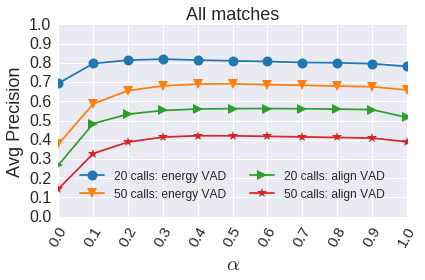

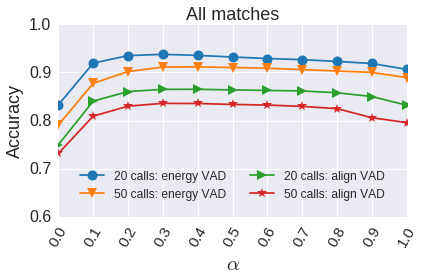

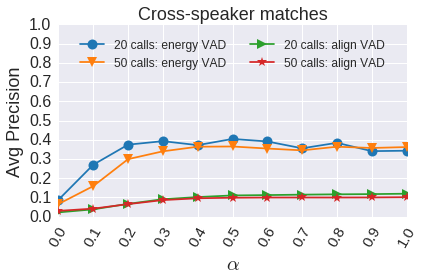

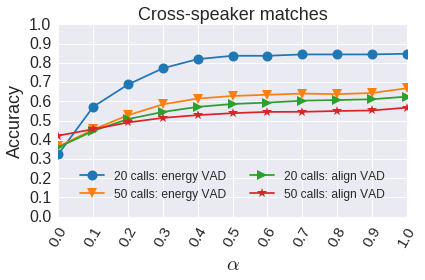

In [87]:
#### N = 4
alpha =  np.arange(0,1.1,0.1)
avg_precision_50_align_vad = np.array([0.144, .328, 0.388, 0.41383, 0.42131, \
                              0.42083, 0.41784, 0.41495, 0.41197, 0.40896, 0.38993])

avg_precision_50_energy_vad = np.array([0.37782, 0.58698, 0.65583, 0.68022, 0.68980, 0.69156, \
                               0.68633, 0.68359, 0.67942, 0.67588, 0.65945])

# ----------------------------------------------------------------------------------------------------------------
# 20 files: energy vad
# ----------------------------------------------------------------------------------------------------------------
# all matches
# ----------------------------------------------------------------------------------------------------------------
ap_20_evad = np.array([0.694, 0.7967, 0.814, 0.8195, 0.8144, 0.8105, 0.8071, 0.8018, 0.8004, 0.7958, 0.7819])
acc_20_evad = np.array([0.8328, 0.9195, 0.9351, 0.9377, 0.9355, 0.9322, 0.929, 0.9267, 0.923, 0.9187, 0.9065])
# ----------------------------------------------------------------------------------------------------------------
# cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
ap_20_evad_x = np.array([0.088, 0.2704, 0.3747, 0.3929, 0.3722, 0.4045, 0.3913, 0.3558, 0.3843, 0.341, 0.3432])
acc_20_evad_x = np.array([0.3263, 0.5719, 0.6877, 0.7719, 0.8193, 0.8368, 0.8368, 0.8439, 0.8439, 0.8439, 0.8474])

# Using Jaccard
# [0.694, 0.8082, 0.8077, 0.7953, 0.7756, 0.7704, 0.7679, 0.7619, 0.7508, 0.7029, 0.368]
# [0.8328, 0.9198, 0.9155, 0.9113, 0.9002, 0.8924, 0.8928, 0.8902, 0.8831, 0.8734, 0.8193]
# [0.088, 0.2551, 0.2769, 0.2538, 0.2617, 0.2567, 0.2435, 0.2533, 0.2536, 0.2467, 0.1]
# [0.3263, 0.7491, 0.7702, 0.8175, 0.8421, 0.8439, 0.8333, 0.8386, 0.8298, 0.8228, 0.8684]
# Using match
# [0.694, 0.8082, 0.8077, 0.7953, 0.7756, 0.7704, 0.7679, 0.7619, 0.7508, 0.7029, 0.368]
# [0.8328, 0.9198, 0.9155, 0.9113, 0.9002, 0.8924, 0.8928, 0.8902, 0.8831, 0.8734, 0.8193]
# [0.088, 0.2551, 0.2769, 0.2538, 0.2617, 0.2567, 0.2435, 0.2533, 0.2536, 0.2467, 0.1]
# [0.3263, 0.7491, 0.7702, 0.8175, 0.8421, 0.8439, 0.8333, 0.8386, 0.8298, 0.8228, 0.8684]
# ----------------------------------------------------------------------------------------------------------------
# 50 files: energy vad
# ----------------------------------------------------------------------------------------------------------------
# all matches
# ----------------------------------------------------------------------------------------------------------------
ap_50_evad = np.array([0.3778, 0.587, 0.6558, 0.6802, 0.6898, 0.6916, 0.6863, 0.6836, 0.6794, 0.6759, 0.6594])
acc_50_evad = np.array([0.791, 0.8776, 0.9019, 0.9113, 0.9116, 0.9103, 0.9089, 0.906, 0.903, 0.9002, 0.8894])
# ----------------------------------------------------------------------------------------------------------------
# cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
ap_50_evad_x = np.array([0.0659, 0.1592, 0.2994, 0.3401, 0.364, 0.3652, 0.3545, 0.3451, 0.364, 0.3575, 0.3622])
acc_50_evad_x = np.array([0.3654, 0.4537, 0.5279, 0.5843, 0.6142, 0.6279, 0.6341, 0.6402, 0.6374, 0.6432, 0.6677])

# Using Jaccard
# [0.3778, 0.5855, 0.6498, 0.6717, 0.6834, 0.6848, 0.6817, 0.6777, 0.6733, 0.6696, 0.6527]
# [0.791, 0.8728, 0.899, 0.9082, 0.9091, 0.9081, 0.9072, 0.904, 0.9008, 0.8977, 0.8866]
# [0.0659, 0.1396, 0.2605, 0.3005, 0.3214, 0.3148, 0.3184, 0.3172, 0.3092, 0.3081, 0.3073]
# [0.3654, 0.4366, 0.5125, 0.5598, 0.5918, 0.6106, 0.6238, 0.6302, 0.6305, 0.6386, 0.6628]

# Using content match
# [0.3778, 0.5445, 0.5328, 0.525, 0.5072, 0.5132, 0.5018, 0.5017, 0.4999, 0.5171, 0.1894]
# [0.791, 0.8732, 0.8686, 0.8635, 0.8543, 0.8527, 0.8492, 0.8465, 0.8395, 0.829, 0.7853]
# [0.0659, 0.1248, 0.122, 0.1181, 0.1239, 0.1215, 0.1202, 0.1268, 0.1267, 0.0844, 0.059]
# [0.3654, 0.5317, 0.5406, 0.5518, 0.5555, 0.5706, 0.5663, 0.5731, 0.5685, 0.5857, 0.6276]
# ----------------------------------------------------------------------------------------------------------------
# 20 files: align vad
# ----------------------------------------------------------------------------------------------------------------
# all matches
# ----------------------------------------------------------------------------------------------------------------
ap_20_avad = np.array([0.2687, 0.4842, 0.5334, 0.5526, 0.56, 0.5621, 0.5625, 0.5614, 0.5596, 0.557, 0.5169])
acc_20_avad = np.array([0.7499, 0.8405, 0.8603, 0.8649, 0.865, 0.8638, 0.8626, 0.8616, 0.8578, 0.85, 0.832])
# ----------------------------------------------------------------------------------------------------------------
# cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
ap_20_avad_x = np.array([0.0226, 0.0383, 0.067, 0.091, 0.1023, 0.1107, 0.1126, 0.1148, 0.1165, 0.1176, 0.1197])
acc_20_avad_x = np.array([0.3611, 0.4463, 0.5077, 0.5449, 0.5712, 0.5862, 0.5933, 0.6033, 0.6067, 0.6107, 0.6244])

# Using Jaccard
# [0.2687, 0.4843, 0.5323, 0.5534, 0.562, 0.565, 0.5654, 0.5647, 0.5627, 0.56, 0.5195]
# [0.7499, 0.8397, 0.8595, 0.8649, 0.8651, 0.8642, 0.8632, 0.8624, 0.8584, 0.8505, 0.8324]
# [0.0226, 0.038, 0.0655, 0.0879, 0.1003, 0.1071, 0.1093, 0.1123, 0.1128, 0.1135, 0.1175]
# [0.3611, 0.4426, 0.5, 0.5442, 0.5681, 0.5837, 0.5919, 0.6025, 0.6052, 0.6092, 0.6234]

# Using match
# [0.2687, 0.4609, 0.4483, 0.435, 0.4277, 0.4243, 0.4252, 0.4249, 0.4221, 0.408, 0.1851]
# [0.7499, 0.8506, 0.8457, 0.8383, 0.8337, 0.8315, 0.8309, 0.8305, 0.8254, 0.8095, 0.7686]
# [0.0226, 0.0499, 0.0503, 0.0504, 0.0504, 0.0504, 0.05, 0.0505, 0.051, 0.0521, 0.0371]
# [0.3611, 0.5638, 0.5736, 0.5789, 0.5814, 0.5849, 0.5846, 0.5924, 0.5973, 0.6041, 0.6339]

# ----------------------------------------------------------------------------------------------------------------
# 50 files: align vad
# ----------------------------------------------------------------------------------------------------------------
# all matches
ap_50_avad = np.array([0.1449, 0.3287, 0.3882, 0.4138, 0.4213, 0.4208, 0.4178, 0.415, 0.412, 0.409, 0.3899])
acc_50_avad = np.array([0.7317, 0.8093, 0.83, 0.8358, 0.8355, 0.8335, 0.8322, 0.8295, 0.8248, 0.806, 0.7957])
# ----------------------------------------------------------------------------------------------------------------
# cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
ap_50_avad_x = np.array([0.0305, 0.0421, 0.0655, 0.0865, 0.0959, 0.0988, 0.0999, 0.1, 0.0999, 0.1003, 0.1016])
acc_50_avad_x = np.array([0.4217, 0.4552, 0.4901, 0.5139, 0.5283, 0.5384, 0.545, 0.5455, 0.5497, 0.5525, 0.5669])

# Using Jaccard
[0.1449, 0.2841, 0.2713, 0.2613, 0.2573, 0.2554, 0.2563, 0.2542, 0.2472, 0.2454, 0.1027]
[0.7317, 0.8193, 0.8147, 0.8093, 0.8057, 0.8035, 0.8032, 0.8005, 0.794, 0.7621, 0.7389]
[0.0305, 0.0567, 0.0566, 0.0563, 0.0564, 0.0562, 0.057, 0.0565, 0.0561, 0.0527, 0.0369]
[0.4217, 0.5239, 0.5293, 0.5334, 0.5343, 0.5364, 0.5386, 0.5366, 0.5398, 0.5487, 0.57]
# Using match
# [0.1449, 0.2841, 0.2713, 0.2613, 0.2573, 0.2554, 0.2563, 0.2542, 0.2472, 0.2454, 0.1027]
# [0.7317, 0.8193, 0.8147, 0.8093, 0.8057, 0.8035, 0.8032, 0.8005, 0.794, 0.7621, 0.7389]
# [0.0305, 0.0567, 0.0566, 0.0563, 0.0564, 0.0562, 0.057, 0.0565, 0.0561, 0.0527, 0.0369]
# [0.4217, 0.5239, 0.5293, 0.5334, 0.5343, 0.5364, 0.5386, 0.5366, 0.5398, 0.5487, 0.57]
# ----------------------------------------------------------------------------------------------------------------
# Plots
# ----------------------------------------------------------------------------------------------------------------
markers = ["o","v",">",'*']
labels = ['20 calls: energy VAD', '50 calls: energy VAD', '20 calls: align VAD', '50 calls: align VAD']
colors = [0, 2, 4, 6]
titles = ["Avg Precision", "Accuracy", \
          "Avg Precision", "Accuracy"]
plot_names = ["output/ap_all.pdf", "output/acc_all.pdf", \
              "output/ap_x.pdf", "output/acc_x.pdf"]
fig_size = (6,4)
ap_arrays = [ap_20_evad, ap_50_evad, ap_20_avad, ap_50_avad]
acc_arrays = [acc_20_evad, acc_50_evad, acc_20_avad, acc_50_avad]
ap_x_arrays = [ap_20_evad_x, ap_50_evad_x, ap_20_avad_x, ap_50_avad_x]
acc_x_arrays = [acc_20_evad_x, acc_50_evad_x, acc_20_avad_x, acc_50_avad_x]
# ----------------------------------------------------------------------------------------------------------------
# Avg. Precision for all matches
# ----------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=fig_size)
for i, arr_data in enumerate(ap_arrays):
    ax.plot(alpha, arr_data, marker=markers[i], color=tableau20[colors[i]], label=labels[i], markersize=10)
ax.yaxis.set_major_locator(MultipleLocator(.1))
ax.set_ylim(0,1)
ax.set_title('All matches', size=18)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.3),
                  ncol=2, fancybox=True, shadow=True, fontsize=12)
format_metrics_plot(ax, fig, titles[0], plotname=plot_names[0], showlegend=True)
# ----------------------------------------------------------------------------------------------------------------
# Accuracy for all matches
# ----------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=fig_size)
for i, arr_data in enumerate(acc_arrays):
    ax.plot(alpha, arr_data, marker=markers[i], color=tableau20[colors[i]], label=labels[i], markersize=10)
ax.yaxis.set_major_locator(MultipleLocator(.1))
ax.set_ylim(0.6,1)
ax.set_title('All matches', size=18)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.3),
                  ncol=2, fancybox=True, shadow=True, fontsize=12)
format_metrics_plot(ax, fig, titles[1], plotname=plot_names[1], showlegend=True)
# ----------------------------------------------------------------------------------------------------------------
# Avg. Precision for cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=fig_size)
for i, arr_data in enumerate(ap_x_arrays):
    ax.plot(alpha, arr_data, marker=markers[i], color=tableau20[colors[i]], label=labels[i], markersize=10)
ax.yaxis.set_major_locator(MultipleLocator(.1))
ax.set_ylim(0,1.0)
ax.set_title('Cross-speaker matches', size=18)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.98),
                  ncol=2, fancybox=True, shadow=True, fontsize=12)
format_metrics_plot(ax, fig, titles[2], plotname=plot_names[2], showlegend=True)
# ----------------------------------------------------------------------------------------------------------------
# Accuracy for cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=fig_size)
for i, arr_data in enumerate(acc_x_arrays):
    ax.plot(alpha, arr_data, marker=markers[i], color=tableau20[colors[i]], label=labels[i], markersize=10)
ax.yaxis.set_major_locator(MultipleLocator(.1))
ax.set_ylim(0,1)
ax.set_title('Cross-speaker matches', size=18)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.3),
                  ncol=2, fancybox=True, shadow=True, fontsize=12)
format_metrics_plot(ax, fig, titles[3], plotname=plot_names[3], showlegend=True)



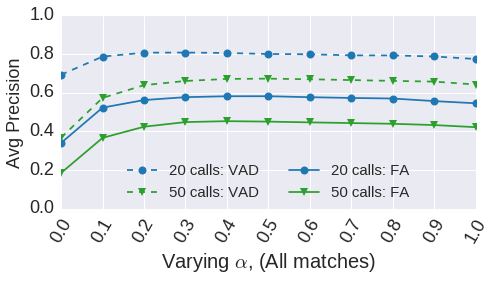

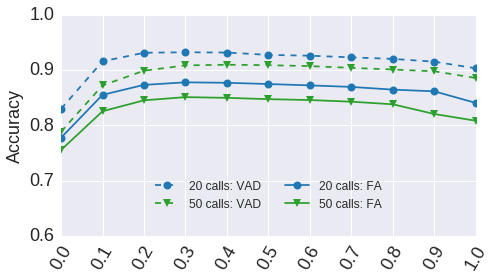

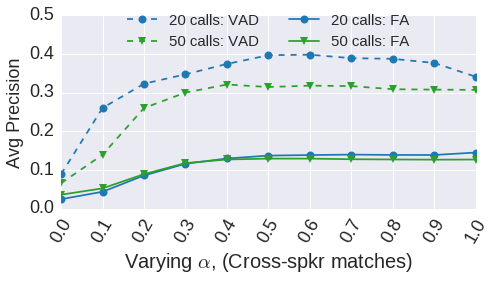

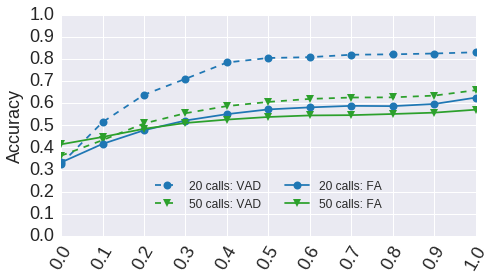

In [136]:
# USING JACCARD

#### N = 4
alpha =  np.arange(0,1.1,0.1)
avg_precision_50_align_vad = np.array([0.144, .328, 0.388, 0.41383, 0.42131, \
                              0.42083, 0.41784, 0.41495, 0.41197, 0.40896, 0.38993])

avg_precision_50_energy_vad = np.array([0.37782, 0.58698, 0.65583, 0.68022, 0.68980, 0.69156, \
                               0.68633, 0.68359, 0.67942, 0.67588, 0.65945])

# ----------------------------------------------------------------------------------------------------------------
# 20 files: energy vad
# ----------------------------------------------------------------------------------------------------------------
# all matches
# ----------------------------------------------------------------------------------------------------------------
ap_20_evad = np.array([0.6939, 0.7877, 0.808, 0.8087, 0.8064, 0.8011, 0.7997, 0.7941, 0.7938, 0.7883, 0.7752])
acc_20_evad = np.array([0.8301, 0.9162, 0.9317, 0.9326, 0.9321, 0.9278, 0.9264, 0.9234, 0.9206, 0.9155, 0.9036])
# ----------------------------------------------------------------------------------------------------------------
# cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
ap_20_evad_x = np.array([0.0894, 0.2609, 0.3236, 0.348, 0.3748, 0.3974, 0.3988, 0.3898, 0.3881, 0.3774, 0.3417])
acc_20_evad_x = np.array([0.3259, 0.5148, 0.6389, 0.7111, 0.7852, 0.8056, 0.8093, 0.8204, 0.8222, 0.8259, 0.8315])

# ----------------------------------------------------------------------------------------------------------------
# 50 files: energy vad
# ----------------------------------------------------------------------------------------------------------------
# all matches
# ----------------------------------------------------------------------------------------------------------------
ap_50_evad = np.array([0.368, 0.5739, 0.6398, 0.6616, 0.6721, 0.6736, 0.6704, 0.6662, 0.662, 0.6582, 0.6431])
acc_50_evad = np.array([0.7888, 0.8725, 0.8992, 0.9088, 0.91, 0.9092, 0.9075, 0.9044, 0.9013, 0.8981, 0.886])
# ----------------------------------------------------------------------------------------------------------------
# cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
ap_50_evad_x = np.array([0.0661, 0.1398, 0.2607, 0.3007, 0.3216, 0.3151, 0.3187, 0.3175, 0.3094, 0.3084, 0.3077])
acc_50_evad_x = np.array([0.3626, 0.4332, 0.5089, 0.5553, 0.5876, 0.6065, 0.6202, 0.6265, 0.6272, 0.6351, 0.6596])

# ----------------------------------------------------------------------------------------------------------------
# 20 files: align vad
# ----------------------------------------------------------------------------------------------------------------
# all matches
# ----------------------------------------------------------------------------------------------------------------
ap_20_avad = np.array([0.3407, 0.5235, 0.5627, 0.5777, 0.5825, 0.5826, 0.5775, 0.5736, 0.5707, 0.5573, 0.546])
acc_20_avad = np.array([0.7778, 0.8554, 0.8735, 0.8781, 0.8773, 0.875, 0.8726, 0.8698, 0.8649, 0.8618, 0.8408])
# ----------------------------------------------------------------------------------------------------------------
# cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
ap_20_avad_x = np.array([0.0247, 0.044, 0.0861, 0.1165, 0.1301, 0.1376, 0.139, 0.1402, 0.1393, 0.1392, 0.1455])
acc_20_avad_x = np.array([0.3322, 0.4162, 0.478, 0.5223, 0.5511, 0.5726, 0.5818, 0.5887, 0.5874, 0.5972, 0.626])
# ----------------------------------------------------------------------------------------------------------------
# 50 files: align vad
# ----------------------------------------------------------------------------------------------------------------
# all matches
ap_50_avad = np.array([0.1854, 0.367, 0.4246, 0.4487, 0.4535, 0.4511, 0.4472, 0.4436, 0.4398, 0.4333, 0.4223])
acc_50_avad = np.array([0.7555, 0.8257, 0.8455, 0.8513, 0.85, 0.8476, 0.846, 0.843, 0.8383, 0.8207, 0.8085])
# ----------------------------------------------------------------------------------------------------------------
# cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
ap_50_avad_x = np.array([0.0364, 0.0528, 0.0896, 0.1183, 0.1275, 0.1298, 0.1298, 0.1282, 0.1276, 0.1271, 0.1274])
acc_50_avad_x = np.array([0.4143, 0.4476, 0.4846, 0.5111, 0.5264, 0.5383, 0.5453, 0.5466, 0.5518, 0.5579, 0.5713])
# ----------------------------------------------------------------------------------------------------------------
# Plots
# ----------------------------------------------------------------------------------------------------------------
markers = ["o","v","o","v"]
labels = ['20 calls: VAD', '50 calls: VAD', '20 calls: FA', '50 calls: FA']
colors = [0, 4, 0, 4]
linestyles = ['--','--', '-','-']
titles = ["Avg Precision", "Accuracy", \
          "Avg Precision", "Accuracy"]
plot_names = ["output/ap_jcrd_all.pdf", "output/acc_jcrd__all.pdf", \
              "output/ap_jcrd__x.pdf", "output/acc_jcrd__x.pdf"]
fig_size = (7,4)
ap_arrays = [ap_20_evad, ap_50_evad, ap_20_avad, ap_50_avad]
acc_arrays = [acc_20_evad, acc_50_evad, acc_20_avad, acc_50_avad]
ap_x_arrays = [ap_20_evad_x, ap_50_evad_x, ap_20_avad_x, ap_50_avad_x]
acc_x_arrays = [acc_20_evad_x, acc_50_evad_x, acc_20_avad_x, acc_50_avad_x]
# ----------------------------------------------------------------------------------------------------------------
# Avg. Precision for all matches
# ----------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=fig_size)
for i, arr_data in enumerate(ap_arrays):
    ax.plot(alpha, arr_data, marker=markers[i], color=tableau20[colors[i]], \
            label=labels[i], markersize=8, linestyle=linestyles[i])
ax.yaxis.set_major_locator(MultipleLocator(.2))
ax.set_xlabel(r'Varying $\alpha$, (All matches)', size=20)
ax.set_ylim(0,1)
# ax.set_title('All matches', size=20, y=1.02)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.3),
                  ncol=2, fancybox=True, shadow=True, fontsize=15)
format_metrics_plot(ax, fig, titles[0], plotname=plot_names[0], showlegend=True)
# ----------------------------------------------------------------------------------------------------------------
# Accuracy for all matches
# ----------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=fig_size)
for i, arr_data in enumerate(acc_arrays):
    ax.plot(alpha, arr_data, marker=markers[i], color=tableau20[colors[i]], \
            label=labels[i], markersize=8, linestyle=linestyles[i])
ax.yaxis.set_major_locator(MultipleLocator(.1))
ax.set_ylim(0.6,1)
# ax.set_title('All matches', size=18)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.3),
                  ncol=2, fancybox=True, shadow=True, fontsize=12)
format_metrics_plot(ax, fig, titles[1], plotname=plot_names[1], showlegend=True)
# ----------------------------------------------------------------------------------------------------------------
# Avg. Precision for cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=fig_size)
for i, arr_data in enumerate(ap_x_arrays):
    ax.plot(alpha, arr_data, marker=markers[i], color=tableau20[colors[i]], \
            label=labels[i], markersize=8, linestyle=linestyles[i])
ax.yaxis.set_major_locator(MultipleLocator(.1))
ax.set_ylim(0,0.5)
# ax.set_title('Cross-speaker matches', size=20, y=1.02)
ax.set_xlabel(r'Varying $\alpha$, (Cross-spkr matches)', size=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
                  ncol=2, fancybox=True, shadow=True, fontsize=15)
format_metrics_plot(ax, fig, titles[2], plotname=plot_names[2], showlegend=True)
# ----------------------------------------------------------------------------------------------------------------
# Accuracy for cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=fig_size)
for i, arr_data in enumerate(acc_x_arrays):
    ax.plot(alpha, arr_data, marker=markers[i], color=tableau20[colors[i]], \
            label=labels[i], markersize=8, linestyle=linestyles[i])
ax.yaxis.set_major_locator(MultipleLocator(.1))
ax.set_ylim(0,1)
# ax.set_title('Cross-speaker matches', size=18)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.3),
                  ncol=2, fancybox=True, shadow=True, fontsize=12)
format_metrics_plot(ax, fig, titles[3], plotname=plot_names[3], showlegend=True)



In [ ]:
'''
50:FA
At DTW=0.88, total: 11114, correct: 1918, Precision: 0.173, Recall: 0.615, x-spkr: 287
20: FA
At DTW=0.88, total: 2339, correct: 728, Precision: 0.311, Recall: 0.684, x-spkr: 18
50:VAD
At DTW=0.88, total: 490, correct: 138, Precision: 0.282, Recall: 0.758, x-spkr: 11
20:VAD:
At DTW=0.88, total: 90, correct: 52, Precision: 0.578, Recall: 0.788, x-spkr: 1
'''

In [42]:
def get_content_words_in_valid_pairs():
    num_valid = 0
    content_words = []
    for pair in ch.eval_pairs_list:
        if (pair['no_mtch'] == False) and (pair['sil_only'] == False) and \
        (pair['sil_major'] == False) and (pair['cnt_es_w_sim'] == True):
            num_valid += 1
            n1 = pair['n1']
            n2 = pair['n2']
            # add score over content es words            
            content_words_n1 = set(ch.node_dict[n1].es_cnt_words) - set(['sil', 'sp'])
            content_words_n2 = set(ch.node_dict[n2].es_cnt_words) - set(['sil', 'sp'])
            content_words.extend(list(content_words_n1 & content_words_n2))
    print("# of correct pairs: %d" % num_valid)
    return content_words
        

In [46]:
content_words = get_content_words_in_valid_pairs()
print("Total matching content words: %d, unique: %d" % (len(content_words), len(set(content_words))))
# print(" ".join(content_words))

# of correct pairs: 1064
Total matching content words: 1259, unique: 495


In [26]:
df_cnt_goodish.head()

,chid1,chid2,cnt_es_w_check,ES cont match,dur,en_w_cnt_count_sim_0,EN sim,en_w_cnt_jcrd_sim_0,en_w_count_sim_0,en_w_hgr_sim_0,...,sil_sp,uid1,uid2,ZRT,spk1,spk2,cross_spk,sim mixed,sim jcrd,sim match
26,1,1,True,1,510,0,0.000,0.000,1,0.134,...,False,049.003,060.030,0.860,1.049.003,1.060.030,True,0.516,0.516,0.516
34,1,1,True,1,800,1,0.092,0.105,1,0.196,...,False,049.007,049.014,0.908,1.049.007,1.049.014,False,0.582,0.587,0.945
35,1,1,True,1,580,0,0.000,0.000,0,0.000,...,True,049.007,049.021,0.889,1.049.007,1.049.021,False,0.533,0.533,0.533
36,1,1,True,1,630,1,0.084,0.067,1,0.154,...,True,049.007,049.025,0.904,1.049.007,1.049.025,False,0.576,0.569,0.942
50,1,1,True,1,550,1,0.047,0.048,1,0.089,...,True,049.007,049.073,0.880,1.049.007,1.049.073,False,0.547,0.547,0.928


In [16]:
ch.eval_pairs_list[0]

{'chid1': 1,
 'chid2': 1,
 'cnt_es_w_check': False,
 'cnt_es_w_sim': 0,
 'dur': 550,
 'en_w_cnt_count_sim_0': 0,
 'en_w_cnt_hgr_sim_0': 0.0,
 'en_w_cnt_jcrd_sim_0': 0.0,
 'en_w_count_sim_0': 1,
 'en_w_hgr_sim_0': 0.04497145189210283,
 'en_w_jcrd_sim_0': 0.044444444444444446,
 'es_p_sim': 0.5714285714285714,
 'es_w_n1': 'L\xc3\xadNEAS Y ESTABA',
 'es_w_n2': 'QUE EST\xc3\xa1N',
 'es_w_sim': 0,
 'n1': 1,
 'n2': 2,
 'no_mtch': False,
 'sil_major': False,
 'sil_only': False,
 'sil_sp': False,
 'uid1': '049.003',
 'uid2': '049.007',
 'zrt_sim': 0.882}

In [108]:
# for ap_arr, acc_arr in zip(ap_arrays, acc_arrays):
#     #print(ap_arr[0],ap_arr[4])
#     #print(acc_arr[0], acc_arr[4])
#     print("& %.3f & %.3f & %.3f & %.3f \\\\" % (ap_arr[0], ap_arr[4], acc_arr[0], acc_arr[4]))
    
for ap_arr, ap_x_arr in zip(ap_arrays, ap_x_arrays):
    #print(ap_arr[0],ap_arr[4])
    #print(acc_arr[0], acc_arr[4])
    print("& %.3f & %.3f & %.3f & %.3f \\\\" % (ap_arr[0], ap_arr[4], ap_x_arr[0], ap_x_arr[4]))

& 0.694 & 0.806 & 0.089 & 0.375 \\
& 0.368 & 0.672 & 0.066 & 0.322 \\
& 0.341 & 0.583 & 0.025 & 0.130 \\
& 0.185 & 0.454 & 0.036 & 0.128 \\


In [44]:
ch.eval_pairs_list[16545]

{'chid1': 2,
 'chid2': 2,
 'cnt_es_w_check': True,
 'cnt_es_w_sim': 1,
 'dur': 820,
 'en_w_cnt_count_sim_0': 0,
 'en_w_cnt_hgr_sim_0': 0,
 'en_w_count_sim_0': 0,
 'en_w_hgr_sim_0': 0,
 'es_p_sim': 1.0,
 'es_w_n1': 'EXACTAMENTE',
 'es_w_n2': 'EXACTAMENTE',
 'es_w_sim': 1,
 'n1': 626,
 'n2': 626,
 'no_mtch': False,
 'sil_only': False,
 'uid1': '101.050',
 'uid2': '101.050',
 'zrt_sim': 0.889}

In [148]:
ch.es_words_dict['041.187']

[0---20 (ms) :	sil,
 20---280 (ms) :	PUES,
 280---510 (ms) :	NO,
 510---700 (ms) :	sp,
 700---1130 (ms) :	NO,
 1130---1780 (ms) :	DICEN,
 1780---1970 (ms) :	NADA,
 1970---2180 (ms) :	PUES,
 2180---2450 (ms) :	LE,
 2450---2830 (ms) :	SEGUIMOS,
 2830---2860 (ms) :	sp,
 2860---3090 (ms) :	LG,
 3090---3130 (ms) :	sp,
 3130---3410 (ms) :	IGUAL,
 3410---3550 (ms) :	ES,
 3550---3880 (ms) :	MEDIA,
 3880---4000 (ms) :	HORA,
 4000---4070 (ms) :	sp,
 4070---4090 (ms) :	LG,
 4090---5000 (ms) :	sil]

In [270]:
(0.454-0.185) / 0.185 * 100

145.40540540540542

In [28]:
filename2i = {}
with open(ch.ch_config['filename_map'], "r") as in_f:
    for i, file_name in enumerate(in_f, start=1):
        filename2i[file_name.strip()] = i
print(len(filename2i))

120


In [30]:
print(len(ch.es_cnt_words_dict))
for fil in ch.es_words_dict.keys():
#     print(ch.es_words_dict[fil][0], ch.es_words_dict[fil][-1])
    if ('sil' != ch.es_words_dict[fil][0].word) and ('sil' != ch.es_words_dict[fil][-1].word):
        print (w.word, end=', ')

call_ids = [key.split('.')[0] for key in ch.es_words_dict]
print(len(call_ids))
print(len(set(call_ids)))

17532
17532
104


In [ ]:
for no,yes in zip(no_trans, with_trans):
    print((yes-no) / no * 100)

Why are align VAD 50 matches less than forced VAD 20 matches, though there is more speech data

In [ ]:
wav_name = "sp_0897.wav"
# IPython.display.Audio(wav_name)
sr1, y1 = scipy.io.wavfile.read(wav_name)
print(len(y1) / sr1, len(y1) / sr1 / 60.0)
!soxi $wav_name
mfcc1 = mfcc(y1, sr1)
print(mfcc1.shape)

In [ ]:
tmp = ch.matches_file + ".dedups"
!head $tmp

1 2 5 6 7 8 9 10 11 12 15 16 21 22 23 24 27 28 29 30 37 38 39 40 41 42 43 44 45 46 47 48 49 50 53 54 55 56 57 58 61 62 63 64 65 66 67 68 71 72 73 74 75 76 77 78 81 82 83 84 91 92 93 94 97 98 99 100 103 104 105 106 109 110 111 112 113 114 115 116 117 118 119 120 121 122 127 128 131 132 133 134 135 136 139 140 143 144 145 146 147 148 149 150 151 152 153 154 155 156 161 162 163 164 169 170 173 174 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 199 200 201 202 205 206 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 253 254 255 256 257 258 259 260 261 262 263 264 267 268 269 270 271 272 273 274 277 278 281 282 285 286 287 288 291 292 307 308 319 320 323 324 325 326 327 328 331 332 333 334 335 336 337 338 341 342 345 346 351 352 357 358 363 364 373 374 377 378 379 380 381 382 385 386 387 388 389 390 395 396 403 404 405 406 407 408 409 410 41

Plot links:

- http://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot


Bhattacharyya link:
http://www.cs.yorku.ca/~kosta/CompVis_Notes/bhattacharyya.pdf
